# Part A: CA1 Fashion-MNIST image classification

## Name: Quah Johnnie
## Admin No: 2007476

<br>

## Intro:
In this assignment I have explored creating my own model from scratch and also explored many different architectures and have implemented it into my CA1 Deep Learning assignment these architecture includes, ResNet, DenseNet, ResNeXt and CoAtNet. <br><br><b>(Part A: ResNet, DenseNet)</b> | (Part B: ResNeXt, CoAtNet)

<br>

### What's [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)?
Fashion MNIST is a dataset containing greyscaled images of clothing from the fashion company [Zalando](https://www.zalando.co.uk/). It is a dataset developed to replace the simpler MNIST handwritten dataset.

### Goal
The goal is to build, analyze and evaluate multiple models using the Fasion MNIST dataset and eventually settle on a model that is able to generalize well to new data without overfitting.
<br><br>

**All code is original unless attributed**

In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 Ti (UUID: GPU-d8f6553d-27a8-db79-b09d-f7d2dc2f7e37)
GPU 1: NVIDIA GeForce RTX 3080 Ti (UUID: GPU-fc296e80-ac09-eb0a-bbff-271651f504c9)


# 0.0: Imports & Configuration

In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install torch-summary
!pip install -U scikit-learn
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
import torch, re, time, gc, itertools, random, os ,sys
from IPython.display import clear_output
import torch.optim as optim
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import datasets
from torchvision import utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
from copy import copy
import pandas as pd
from collections import OrderedDict
from typing import Any, Callable, List, Optional, Type, Union, Tuple
from sklearn.metrics import classification_report, confusion_matrix
from torchsummary import summary

# from sklearn.preprocessing import OneHotEncoder

sns.set(style="ticks")

# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Set global random seed.
To make sure results are reproduciable.

In [ ]:
np.random.seed(2007476)
torch.manual_seed(2007476)

#### Changing directory for colab (can ignore)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My\ Drive/Skool/2022sem2/DELE/

# 1.0: Dataset Preparation & EDA & Data Understanding
- Importing dataset
- What does each class of FashionMNIST look like?
- What does the 'average' image of FashionMNIST image look like, and what does the 'average' image of each class look like?
- How does the pixel distribution look like?
- Are there any outliers within each class, what do the outliers look like?
- Summary of analysis from EDA.

## 1.1: Dataset Preparation

<b>Sources to get dataset (official):</b> [Kaggle CSV](https://www.kaggle.com/datasets/zalando-research/fashionmnist?resource=download) | [PyTorch Raw Data Documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)

Importing and downloading the raw data from PyTorch's dataset API, turning it into a numpy so I can perform EDA on it

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

class_labels = training_data.classes

train_loader = DataLoader(training_data, batch_size=len(training_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))

train_input = torch.Tensor(next(iter(train_loader))[0].numpy())
test_input = torch.Tensor(next(iter(test_loader))[0].numpy())

train_label = torch.Tensor(next(iter(train_loader))[1].numpy())
test_label = torch.Tensor(next(iter(test_loader))[1].numpy())

del train_loader, test_loader, training_data, test_data

**This is relatively huge batch size...a lower batch size around (32-128) is better as it offer a stronger regularization effect and lower generalization error. However, to speed up my training times I have choosen a relative large batch_size** I will lower the batch size during model improvement/hyperparameter tuning. Stronger data augmentation has been used as well.

In [ ]:
BATCH_SIZE = 1024

## 1.2: EDA of raw dataset

Note that we are exploring the raw dataset of FashionMNIST i.e no data augmentation is done yet.

### FashionMNIST metadata:
Training set of 60,000 examples. <br>
Test set of 10,000 examples. <br>
<u>Total of 70,000 examples.</u>

<br>

<b><u>Labels & Description</u></b>

| Label | Description |
|---|---|
| 0 | T-shirt/top   |
| 1 | Trouser  |
| 2 |  Pullover   |
| 3 |  Dress   |
| 4 |  Coat   |
| 5 |  Sandal   |
| 6 |  Shirt   |
| 7 |  Sneaker   |
| 8 |  Bag   |
| 9 |  Ankle boot   |

[[label source](https://github.com/zalandoresearch/fashion-mnist)]

<br><br>

Side note: Training set will be split into 50,000 and 10,000 examples for training and validation set respectively to prevent overfitting on the test set.

### 1.2.1: Overview of images from each classes
- [Metadata labels](https://github.com/zalandoresearch/fashion-mnist#labels)

T-shirt/top: 6000
Trouser: 6000
Pullover: 6000
Dress: 6000
Coat: 6000
Sandal: 6000
Shirt: 6000
Sneaker: 6000
Bag: 6000
Ankle boot: 6000


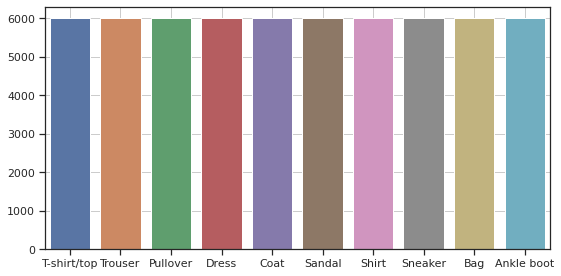

In [ ]:
labels, counts = np.unique(train_label, return_counts=True)
for label, count in zip(labels, counts):
  print(f"{class_labels[int(label)]}: {count}")

fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
sns.barplot(x=class_labels, y=counts, ax=ax)
plt.grid()
plt.tight_layout()

#### Observation to point out:
Off the bat, I can tell that there is the same number of datapoints for each class. It has a uniform distribution in terms of type of datapoints.

How does each class of image look like?

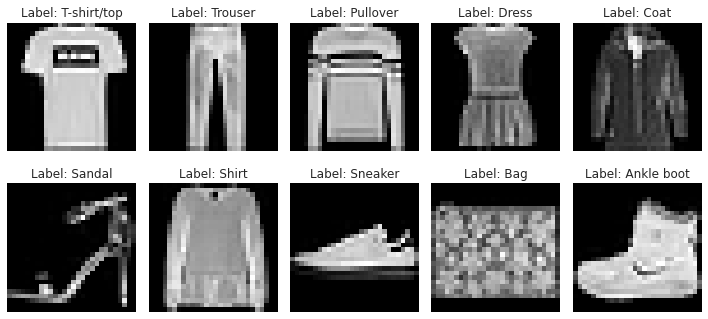

In [ ]:
train_input_np = train_input.numpy().reshape(60000,28,28)

fig, ax = plt.subplots(2, 5, figsize=(10, 5), tight_layout=True)
ax = ax.ravel()
for i in range(10):
    images = train_input_np[np.squeeze(train_label == i)][0]
    label = class_labels[i]
    subplot = ax[i]
    subplot.axis("off")
    subplot.imshow(images, cmap="gray")
    subplot.set_title(f"Label: {label}")

A larger set of images from different class

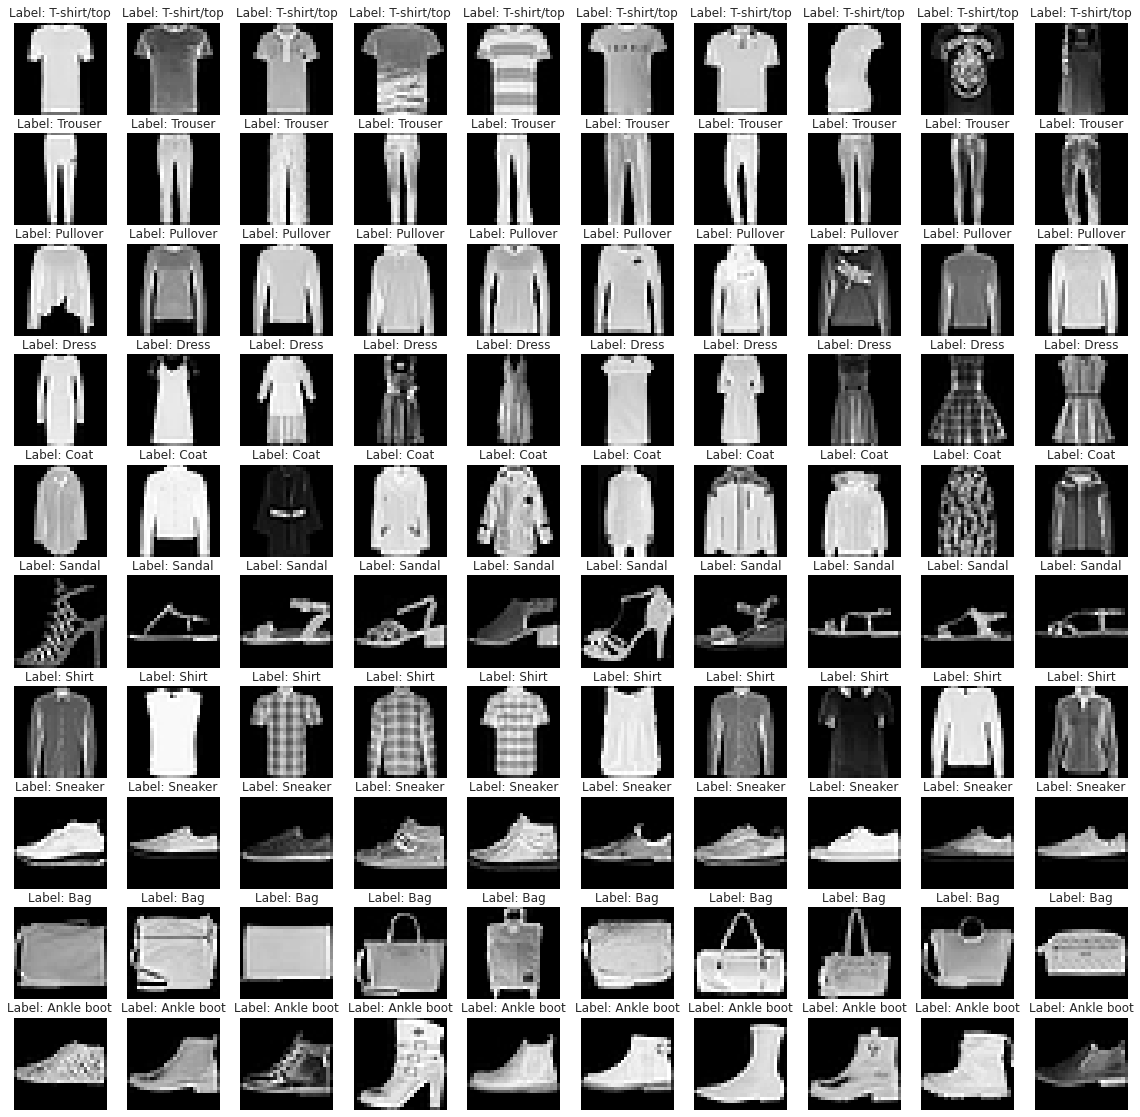

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
  images = train_input_np[np.squeeze(train_label == i)]
  random_idxs = np.random.choice(images.shape[0], 10, replace=False)
  images = images[random_idxs]
  label = class_labels[i]
  for j in range(10):
    subplot = ax[i, j]
    subplot.axis("off")
    subplot.imshow(images[j], cmap="gray")
    subplot.set_title(f"Label: {label}")
fig.show()

#### Observations to point out:
Every class seems to have differing features from one another even though they might look similar. For example, 'Coat, 'Pullover', 'Shirt' and 'T_shirt/top' may look very similar even towards the human eye. However, small difference in features can be seen for example, 'Coat' and 'Shirt' may look similar but 'Shirt' has generally a shorter sleeve and duller look. I suspect those shirt chlothing could be harder to differentiate than the other classes for our model. The images in class 'Bag' seems to differ quite different from one another, the general shape of bag may be similar but they differ very differently interms of its size and design. Some 'Ankle Boot' look rather similar to the general shape of 'Sneaker', vice visa.

How does the 'average' image of each class look like?


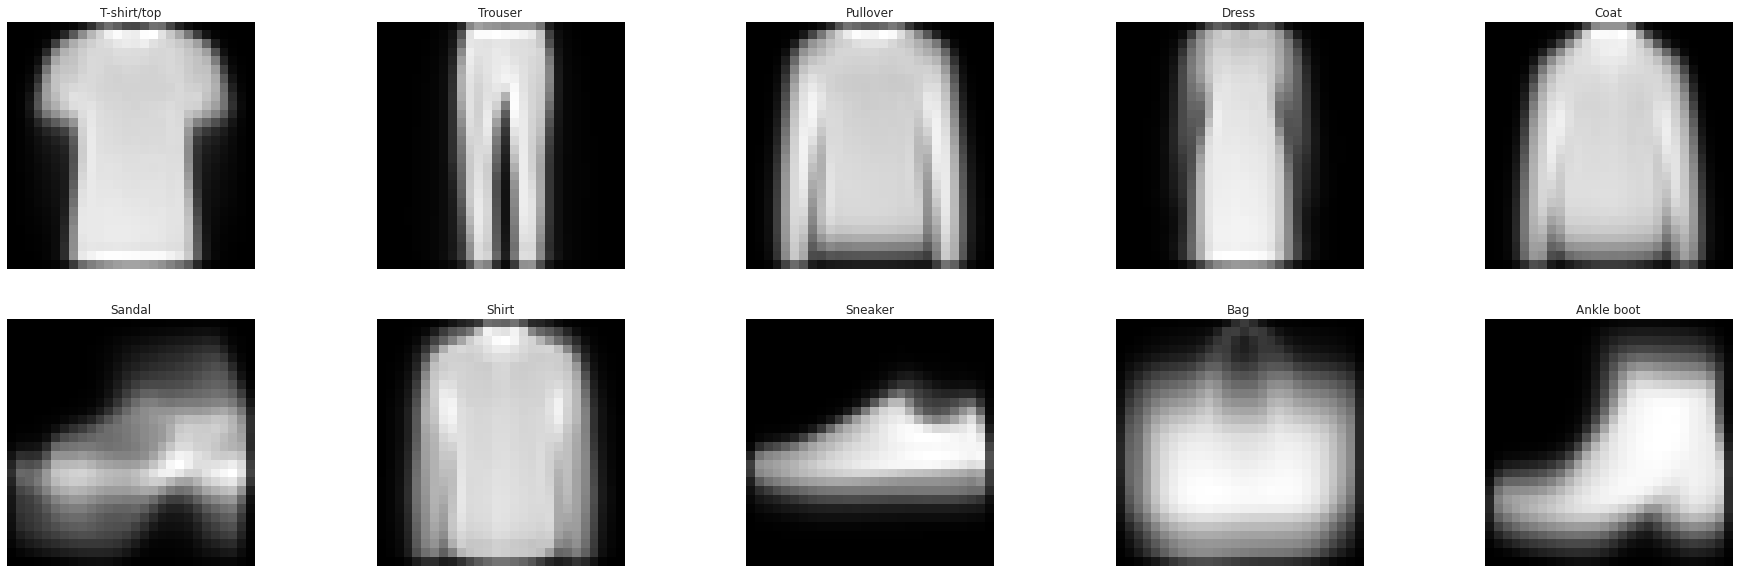

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(32, 10))
for idx, subplot in enumerate(ax.ravel()):
  avg_image = np.mean(train_input_np[np.squeeze(train_label == idx)], axis=0)
  subplot.imshow(avg_image, cmap="gray")
  subplot.set_title(f"{class_labels[idx]}")
  subplot.axis("off")


How does the 'average' image look like all together?

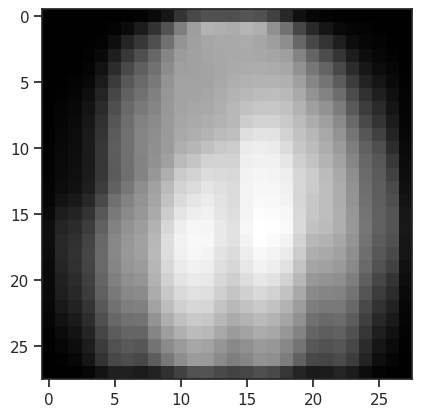

In [ ]:
plt.imshow(np.mean(train_input_np, axis=0), cmap="gray")
plt.show()

#### Observations to point out:
The 'average' image of each class shows us the general shape of each class. As expected the shirt clothing classes seem to have generally pretty similar shape, for example the 'Pullover' and 'Coat' look pretty similar except 'Pullover' seems to have a broader shoulder.

The 'average' image of every class combined shows that the center seems to be the brightest and radiate out with a gradient in a shape of a blob or potato. Which is expected since all the image seems to be centralised.

How does the pixel average distribution look like?

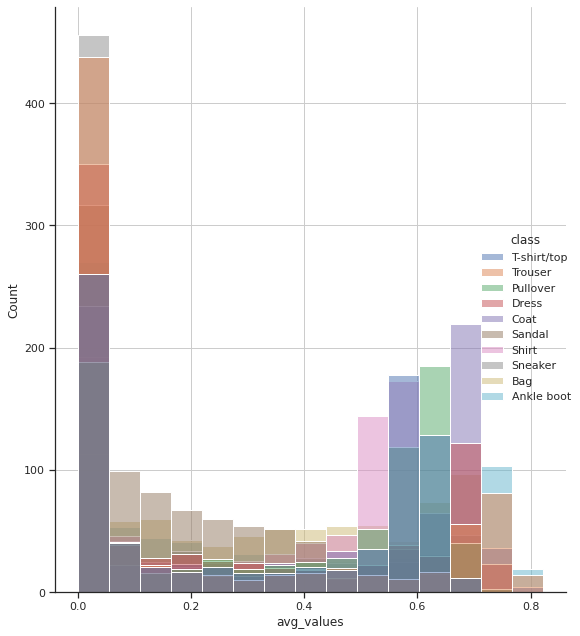

In [ ]:
# To calculate the average pixel distribution from each class
avg_images_df = pd.DataFrame([],columns=['avg_pixel_values','class'])

for idx in range(len(train_label.unique())):
    avg_image = np.mean(train_input_np[np.squeeze(train_label == idx)], axis=0)
    avg_images_df = pd.concat([avg_images_df,pd.DataFrame(avg_image.flatten(),columns=['avg_values'])])
    avg_images_df.reset_index(inplace=True,drop=True)
    avg_images_df.loc[idx*784:(idx+1)*784,'class'] = class_labels[idx]

# To display the average pixel distribution of all the classes
sns.displot(avg_images_df,x='avg_values',hue='class',height=9,aspect=0.75)
plt.grid()
plt.tight_layout()

#### Observations to point out:
Most pixels are generally 0 (dark pixel) which is not surprising as black pixel makes up majority of the images seen perviously, there is a gussian curve from around average pixel value from 0.4 to 0.8 and peaked around 0.65. Sneaker seems to have the most dark values on average. Hence, telling us it has generally the least pixel value. From this graph we can tell that something like 'Sandal' has a lower average pixel value than 'T_ship/top' too. Not much useful insights can be seen other than these few observations, this shows that we can compare much easier by displaying images, nonetheless, it is still decently useful to compare the differing pixel values of different classes.

#### Discussion to find outlier...
#### So what are some ways I can think of to find outliers in images? Understanding outliers is important in data understanding
- 1) To start, the simplest way I thought of would perhaps to compare the MSE (mean squared error) of an image to the average pixel values of its class. For example, if a sneaker is very different from the average sneaker then it would be an outlier. It might work here, however, if the data has 3 channels and much more complex it might not work...

- 2) There are many useful tools such as PCA (Principal Component Analysis) to find outliers. These unsupervised learning techniques will group data with similar looking "components/features" together and the data furthest away from their group would be an outlier.

- 3) Since we are in the topic of deep learning, autoencoders would be perfect. It is an improvement over something like PCA as it uses linear algebra to transform. In contrast, the autoencoder techniques can perform non-linear transformations with their non-linear activation function and multi layers neutral network. It is more efficient to train several layers with an autoencoder, rather than training one huge transformation with PCA.

<br>

There are 2 ways I can use autoencoder to find anomalies, use a trained encoder to reduce its dimensions, datapoints with the highest distance away from its class group average would be outliers. Another way would be to compare the loss (MSE in this case) of the final reconstructed image, this works because autoencoders tries to minimize the reconstruction error as part of its training. Anomalies are detected by checking the magnitude of the reconstruction loss (MSE).

### Autoencoders for outlier analysis will be use!
<img src="https://miro.medium.com/max/1080/1*IGCFwMEZBHrsww8HzBpAEw.png" width="500" alt='Autoencoder structure'>

Preping dataloaders for autoencoder

In [ ]:
train_dataloader_autoencode = DataLoader(TensorDataset(train_input.type('torch.FloatTensor'),train_label.type('torch.FloatTensor')),batch_size=1024,shuffle=True)

# Single batch loader to compare RMSE of each image in each class
def single_loader(label):
    return DataLoader(TensorDataset(train_input.type('torch.FloatTensor')[train_label==label],train_label.type('torch.FloatTensor')[train_label==label]),batch_size=1,shuffle=False)

Initialising simple convolutional autoencoder, loss function, optimizer etc.

In [ ]:
# This autoencoder is original
class SimpleAutoEncoder(nn.Module):
    def __init__(self):
        super(SimpleAutoEncoder, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 32, 3), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32, 16, 3), nn.BatchNorm2d(16), nn.ReLU(True)
        )
        
        # bottleneck
        self.bottleneck = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7744,256), nn.BatchNorm1d(256), nn.ReLU(True),
            nn.Linear(256,7744), nn.BatchNorm1d(7744), nn.ReLU(True),
            nn.Unflatten(1,(16,22,22)) # 7744 = 16 * 22 * 22 (calculation done manually)
        )
        
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 3), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 64, 3), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 3), nn.ReLU(True)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

model = nn.DataParallel(SimpleAutoEncoder())
model = model.to(device)

print(model)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.00025)

def train_ae(net, trainloader, NUM_EPOCHS, displayEvery=5):
#     train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data # no need for the labels
            img = img.to(device)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
#         train_loss.append(loss)
        if (epoch+1)%displayEvery==0:
            print('- Epoch {} of {}, Train Loss: {:.3f}'.format(epoch+1, NUM_EPOCHS, loss))

def get_outliers(net, trainloader):
    net.eval()
    running_loss = np.array([])
    for data in trainloader:
        img, _ = data # no need for the labels
        img = img.to(device)
        optimizer.zero_grad()
        outputs = net(img)
        loss = criterion(outputs, img)
        running_loss = np.append(running_loss,np.array(loss.item()))
        highest6 = np.argsort(running_loss)[::-1][:6] #top 6 highest reconstructed loss
    return highest6

DataParallel(
  (module): SimpleAutoEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (bottleneck): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=7744, out_features=256, bias=True)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=256, out_features=7744, bias=True)
      (5): BatchNorm1d(7744, eps=1e-05, momentum=0.

In [ ]:
train_ae(model, train_dataloader_autoencode, 50)

# Remove the dataloader from memory
del train_dataloader_autoencode

- Epoch 5 of 50, Train Loss: 0.055
- Epoch 10 of 50, Train Loss: 0.034
- Epoch 15 of 50, Train Loss: 0.023
- Epoch 20 of 50, Train Loss: 0.019
- Epoch 25 of 50, Train Loss: 0.017
- Epoch 30 of 50, Train Loss: 0.015
- Epoch 35 of 50, Train Loss: 0.014
- Epoch 40 of 50, Train Loss: 0.013
- Epoch 45 of 50, Train Loss: 0.013
- Epoch 50 of 50, Train Loss: 0.012


Get indices of the reconstructed images with the highest MSE

In [ ]:
outliers = np.array([])
for i in range(10):
    outliers = np.append(outliers,get_outliers(model,single_loader(i)))
outliers = outliers.astype(int)

Display Top 6 outliers from each class

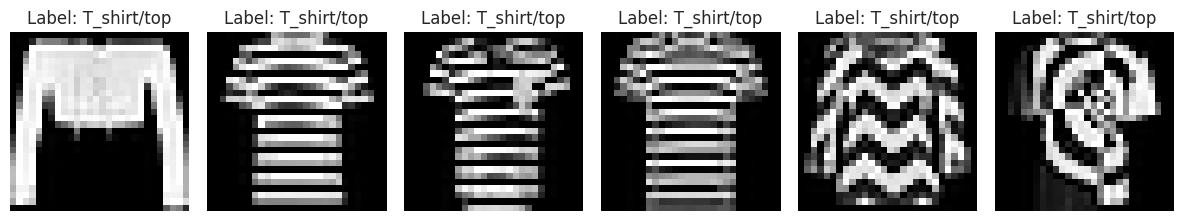

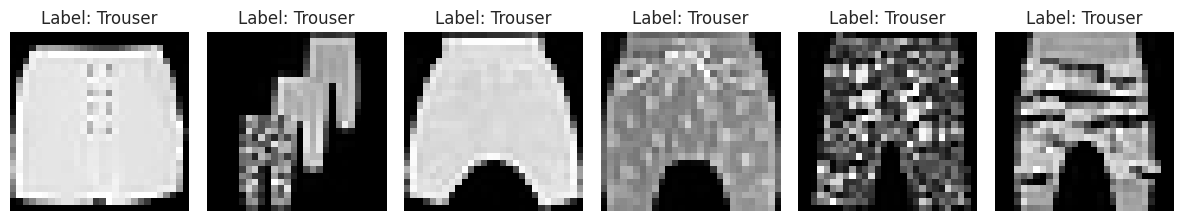

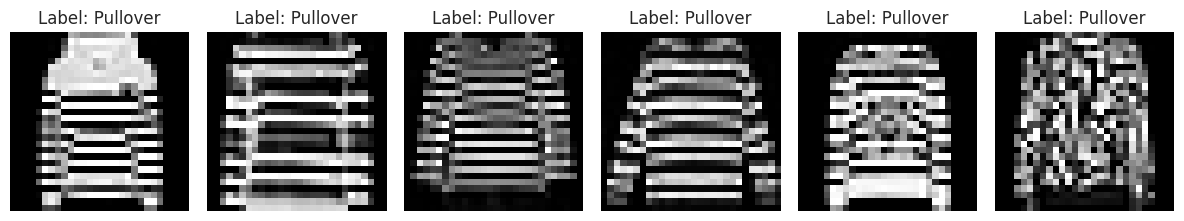

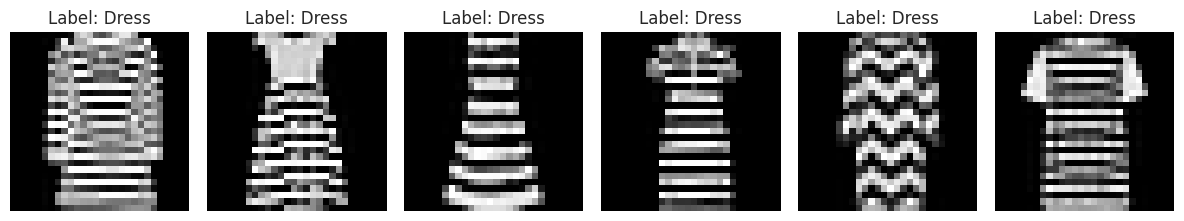

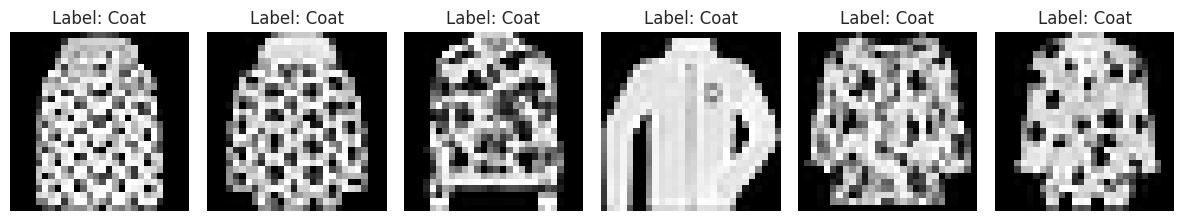

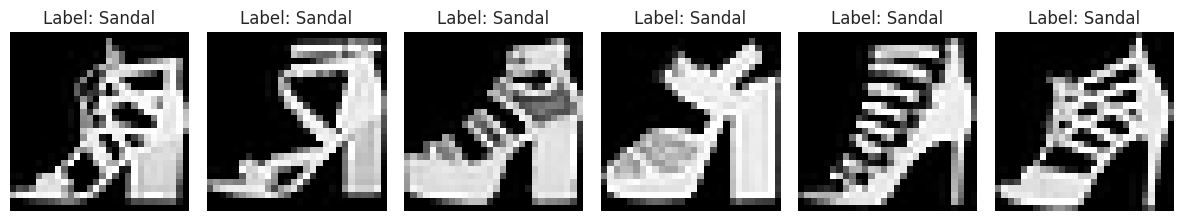

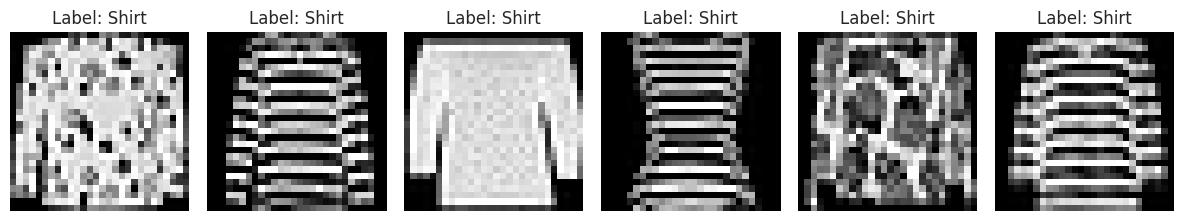

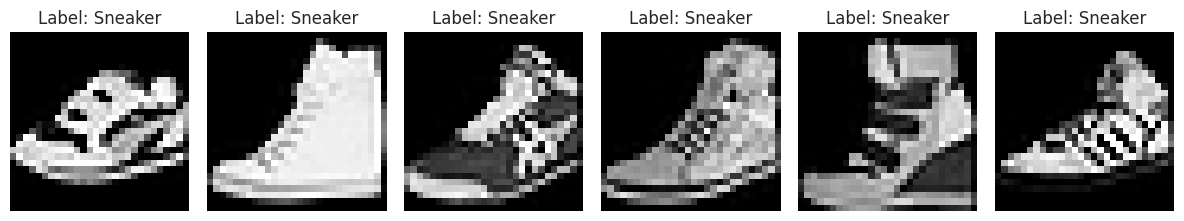

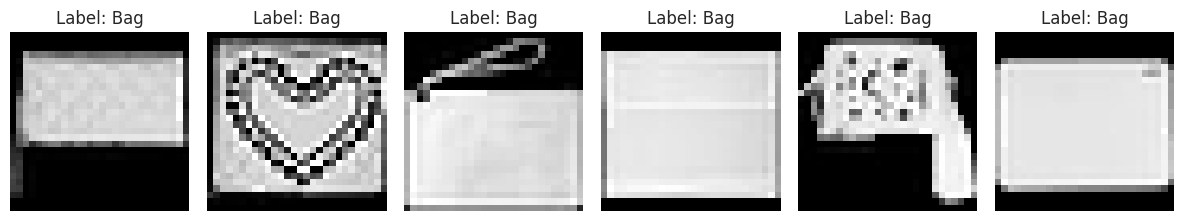

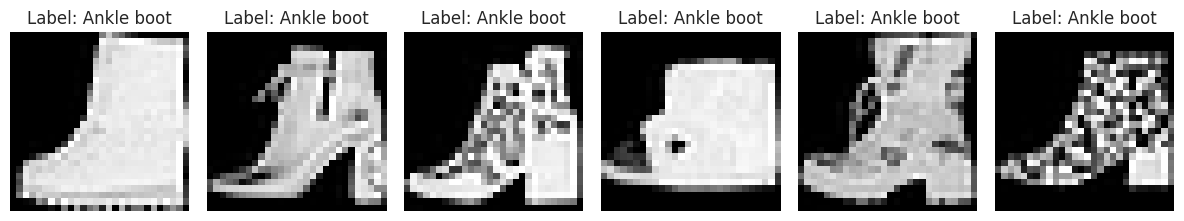

In [ ]:
for e in range(10):
    fig, ax = plt.subplots(1, 6, figsize=(12, 10), tight_layout=True)
    ax = ax.ravel()
    for i in range(6):
        images = train_input_np[train_label==e][outliers][e*6:(e+1)*6][i]
        label = class_labels[e]
        subplot = ax[i]
        subplot.axis("off")
        subplot.imshow(images, cmap="gray")
        subplot.set_title(f"Label: {label}")
del train_input_np

In [ ]:
del model, outliers

#### Observations to point out:
It seems that outliers from our dataset follows a simple general trend, their design is very 'polka-dotty' or stripy or fancy, which in greyscale makes the product look like there are holes or lines inbetween them. As for the shoes it looks like it is taken from a different angle as well. These are definitely some images that might give our model a hard time identifying
<br><br>

*An improvement to finding outlier would be to prehaps train each class on a seperate autoencoder this way the autoencoder will be trained with only training data of their own class. Hence, outliers displayed may be more distinct to their own class. However, this will take much time.*

# 2.0) Feature Engineering/Data Augmentation & More Data Preparation

- Based on pervious analysis which augmentation method could yield the best result?

- Data replication with augmentation

- Preparing multiple datasets with different set of augmentation to see which is the best (for tuning model).


### Some data leakage rules to apply:

- Only the training set should be augmented. The only augmentation that I can apply on the validation/test set would be Normalization (either min-max or z-scaled), note that the values used for Normalization must also be from the _training_ dataset only, this is to minimize data leakage since we should not know any values from the testing data (the difference should be quite eligible but good practice).

- The testing data cannot be used for evaluation at any point only until the final evaluation. These remove any decision making made by using testing data hence removing overfitting of the testing data.

- No information from testing data can be used for training or validation data, and no information from validation data should be used for training data.

## 2.1) Data Preparation
- Splitting training data into training and validation data to prevent overfitting when evaluating different models or hyperparameter tuning
- One Hot Encoding

Note that our training and test data are untouched.

In [ ]:
display(train_input.shape)
display(test_input.shape)

torch.Size([60000, 1, 28, 28])

torch.Size([10000, 1, 28, 28])

I have decided on 50K training, 10K validation and 10K testing data as I figure this is should be enough datapoints for me to evaluate and choose my best model. Furthermore, with a bit of background research some state-of-the-art models used similar data split to achieve their results (48K training and 12K validation is a common split too). <br>

Resources: [ [Papers With Code (FashionMNIST state-of-the-art models)](https://paperswithcode.com/sota/image-classification-on-fashion-mnist) ] <br>

| Split | Size |
|---|---|
| Training | 50K   |
| Validation | 10K  |
| Testing |  10k   |

<br>

The same training data will be used for data replication with data augmentation instead of replacing the image, this is to retain and replicate as much similar looking data as what we supposed to expect in the real-world (in this case our test data)

In [ ]:
traindata_input = train_input[:50000]
valdata_input = train_input[50000:]
# del train_input

# One hot encoded labels
traindata_label = F.one_hot(train_label.type('torch.LongTensor')[:50000],10)
valdata_label = F.one_hot(train_label.type('torch.LongTensor')[50000:],10)

train_label = F.one_hot(train_label.type('torch.LongTensor'),10)
# del train_label

test_label = F.one_hot(test_label.type('torch.LongTensor'),10)

display(traindata_input.shape)
display(valdata_input.shape)

torch.Size([50000, 1, 28, 28])

torch.Size([10000, 1, 28, 28])

### Important thing about data augmentation:
How do we know that which data augmentation is better? Does doing data augmentation really improve accuracy
<br><br>

Before we continue with data augmentation there are a few sets of training datasets I would like to prepare, these sets of datasets will be used to evaluate later to find out whether it is better to use augmentation. Some of these data augmentation are chosen based on my background research and intuition (sources and explanation below)<br><br>

Here is what I have settled on

| Split | Size | Description |
|---|---|---|
| Trainset 1 | 50K  | Normalization (min-max) |
| Trainset 2 (Replicated Data) |  50k + 50k   | Normalization (min-max), RandomHorizontalFlip(0.8), RandomErasing() |
| Trainset 3 (Replicated Data) |  50k + 50k   | Normalization (min-max), RandomHorizontalFlip(0.8), RandomRotation(-5,5) |
| Trainset 4 (Replicated Data) |  50k + 50k   | Normalization (min-max), RandomHorizontalFlip(0.8), RandomErasing(), RandomRotation(5) |
| Trainset 5 (Replicated Data) |  50k + 50k   | Normalization (min-max), RandomErasing(), RandomRotation(-5,5) |
| Trainset 6 (Replicated Data) | 50K + 50k  | Normalization (min-max), RandomHorizontalFlip(0.8), RandomPerspective(0.115,0.4), RandomErasing() |

<br><br>

### All data will be scaled:
<b>Why scale data anyways?</b> Many experiments have that normalization have improve neutral network stability and modeling performance. Differences in the scales across input variables may increase the difficulty of the problem being modeled. An example of this is that large input values (e.g. a spread of hundreds or thousands of units) can result in a model that learns large weight values. A model with large weight values is often unstable, meaning that it may suffer from poor performance during learning and sensitivity to input values resulting in higher generalization error. By scaling your data the multi-dimensional local minima will be more 'symmtrical' and less spread out as well since the values are scaled. Hence, improving model performances [[Andrew Ng, 2017, unofficial source](https://www.youtube.com/watch?v=tNIpEZLv_eg&t=49s)].<br>


### <u>Reasons for augmentation choices:<br></u>


<u>Trainset 1</u>: A simple dataset that does not have any data augmentation besides min-max normalization<br>

<u>Trainset 2</u>: This dataset contain 100K samples where the first 50K is normal datapoints that are normalized (min-max), and RandomHorizontalFlip is applied to replicate more data samples while still being slightly different (especially for shoes). RandomErasing is used to implement noise into our dataset, which also gives the affect of regularization into our normal. The researchers that first implemented RandomErasing were able to achieve state-of-the-art performances on FashionMNIST & ImageNet back in 2017 [[Zhong, 2017](https://paperswithcode.com/paper/random-erasing-data-augmentation)]. However, note that newer augmentation methods have since outperformed random erasing (similar to CutOut).<br>

<u>Trainset 3</u>: This dataset has RandomRotation instead of RandomErasing. RandomErasing may be providing too much noise therefore it is replaced with RandomRotation. RandomRotation of 5 degrees is introduced. This extra rotate may introduced a good amount of replication and noise into our dataset that it might improve our model. Model evaluation would still has to be done with all these datasets.<br>

<u>Trainset 4</u>: This dataset contain the same combined augmentation configuration as Trainset 3&4.<br>

<u>Trainset 5</u>: This dataset contain the same augmentation configuration as Trainset 5. However, horizontalflip is removed because most of the shoe data are pointed towards the left, perhaps, the model might produce a better result without horizontal flipping.<br>

<u>Trainset 6</u>: This dataset contain a combined augmentation effect of slight random rotation and distortion to create random perspective as though the image is viewed from a different angle. A low distortiona and probability is used, and RandomErasing is used to implement noise.
<br><br>

Since this dataset only contain 1 channel (greyscale), I will opt out on using augmentation that augment the color of the image

### Calculating values to use for Normalization (min-max & z-scale)

min-max scaling: <br>

${x'}$ = $\frac{x - min(x)}{max(x) - min(x)}$<br>

<br><br>

z-score scaling: <br>

${z}$ = $\frac{x - \mu}{\sigma}$<br>

where,<br>
${\mu}$ = mean pixel value of our training dataset<br>
${\sigma}$ = std pixel value of our training dataset


In [ ]:
train_mean = traindata_input.mean()
train_std = traindata_input.std()


print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(traindata_input.min(), traindata_input.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(train_mean, train_std))

Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.2854989171028137 
Pixel Values Std: 0.3527844548225403


Since min pixel value is 0 the formula for min-max scaling simiplifies to<br>

${x'}$ = $\frac{x}{1}$<br>

...seems like my dataset is already normalized when I downloaded it from the PyTorch API. However, usually I would have to divide it by 255 on raw images (max pixel value - min pixel value)

## 2.2) Applying the different augmentation techniques

### 2.2.1) Trainset 1
- Normalization (min-max)
- No augmentation

In [ ]:
trainset1 = traindata_input

# These dataset will remain unchange, just changing name
valset = valdata_input
testset = test_input
del valdata_input, test_input

display(trainset1.min())
display(trainset1.max())

tensor(0.)

tensor(1.)

In [ ]:
def DataAugment(train_set,composeAug,batch_size=1):
    # if single_batch:
    stack = torch.tensor([], dtype=torch.float)
    for i in range(int(len(train_set)/batch_size)):
        stack = torch.cat((stack,composeAug(train_set[i*batch_size:(i+1)*batch_size])))
    return stack

    
# Initialization of different augmentation methods
hFlip_RE = transforms.Compose([transforms.RandomHorizontalFlip(0.8),
                            transforms.RandomErasing()])
hFlip_Rotate = transforms.Compose([transforms.RandomHorizontalFlip(0.8),
                            transforms.Compose([transforms.RandomRotation((-5,5))])])
RE_Rotate =  transforms.Compose([transforms.RandomErasing(),
                        transforms.Compose([transforms.RandomRotation((-5,5))])])
randRotate = transforms.Compose([transforms.RandomRotation((-5,5))])
randPrespec = transforms.Compose([transforms.RandomHorizontalFlip(0.8),transforms.RandomErasing(),transforms.RandomPerspective(0.115,0.4)])

### 2.2.2) Trainset 2
- Replicate Data
- Normalization (min-max), RandomHorizontalFlip(0.8), RandomErasing()

In [ ]:
trainset2_rep = DataAugment(trainset1,hFlip_RE,50)
trainset2 = torch.cat((trainset1,trainset2_rep))

trainset2.shape

torch.Size([100000, 1, 28, 28])

### 2.2.3) Trainset 3
- Replicate Data
- Normalization (min-max), RandomHorizontalFlip(0.8), RandomRotation(5)

In [ ]:
trainset3_rep = DataAugment(trainset1,hFlip_Rotate,50)
trainset3 = torch.cat((trainset1,trainset3_rep))
del trainset3_rep

trainset3.shape

torch.Size([100000, 1, 28, 28])

### 2.2.4) Trainset 4
- Replicate Data
- Normalization (min-max), RandomHorizontalFlip(0.8), RandomErasing(), RandomRotation(-5,5)

In [ ]:
trainset4_rep = DataAugment(trainset2_rep,randRotate,50)
trainset4 = torch.cat((trainset1,trainset4_rep))


trainset4.shape

torch.Size([100000, 1, 28, 28])

### 2.2.5) Trainset 5
- Replicate Data
- Normalization (min-max), RandomErasing(), RandomRotation(-5,5)

In [ ]:
trainset5_rep = DataAugment(trainset1,RE_Rotate,50)
trainset5 = torch.cat((trainset1,trainset5_rep))

# Training data with 100K labels
trainset5.shape

torch.Size([100000, 1, 28, 28])

### 2.2.6) Trainset 6
- Replicate Data
- Normalization (min-max), RandomErasing(), RandomPrespective(0.115,0.4)

In [ ]:
trainset6_rep = DataAugment(trainset1,randPrespec,50)
trainset6 = torch.cat((trainset1,trainset6_rep))
del RE_Rotate, trainset5_rep, trainset2_rep, hFlip_Rotate, randPrespec

# Training data with 100K labels
traindata_label_100k = torch.cat((traindata_label,traindata_label))
trainset6.shape

torch.Size([100000, 1, 28, 28])

## 2.3) Observing the augmented data
- Slightly more EDA & Data Understanding
- <b>I will simply show the augmented data for trainset4 & trainset6, since they contain all the augmentation used.</b>

trainset4

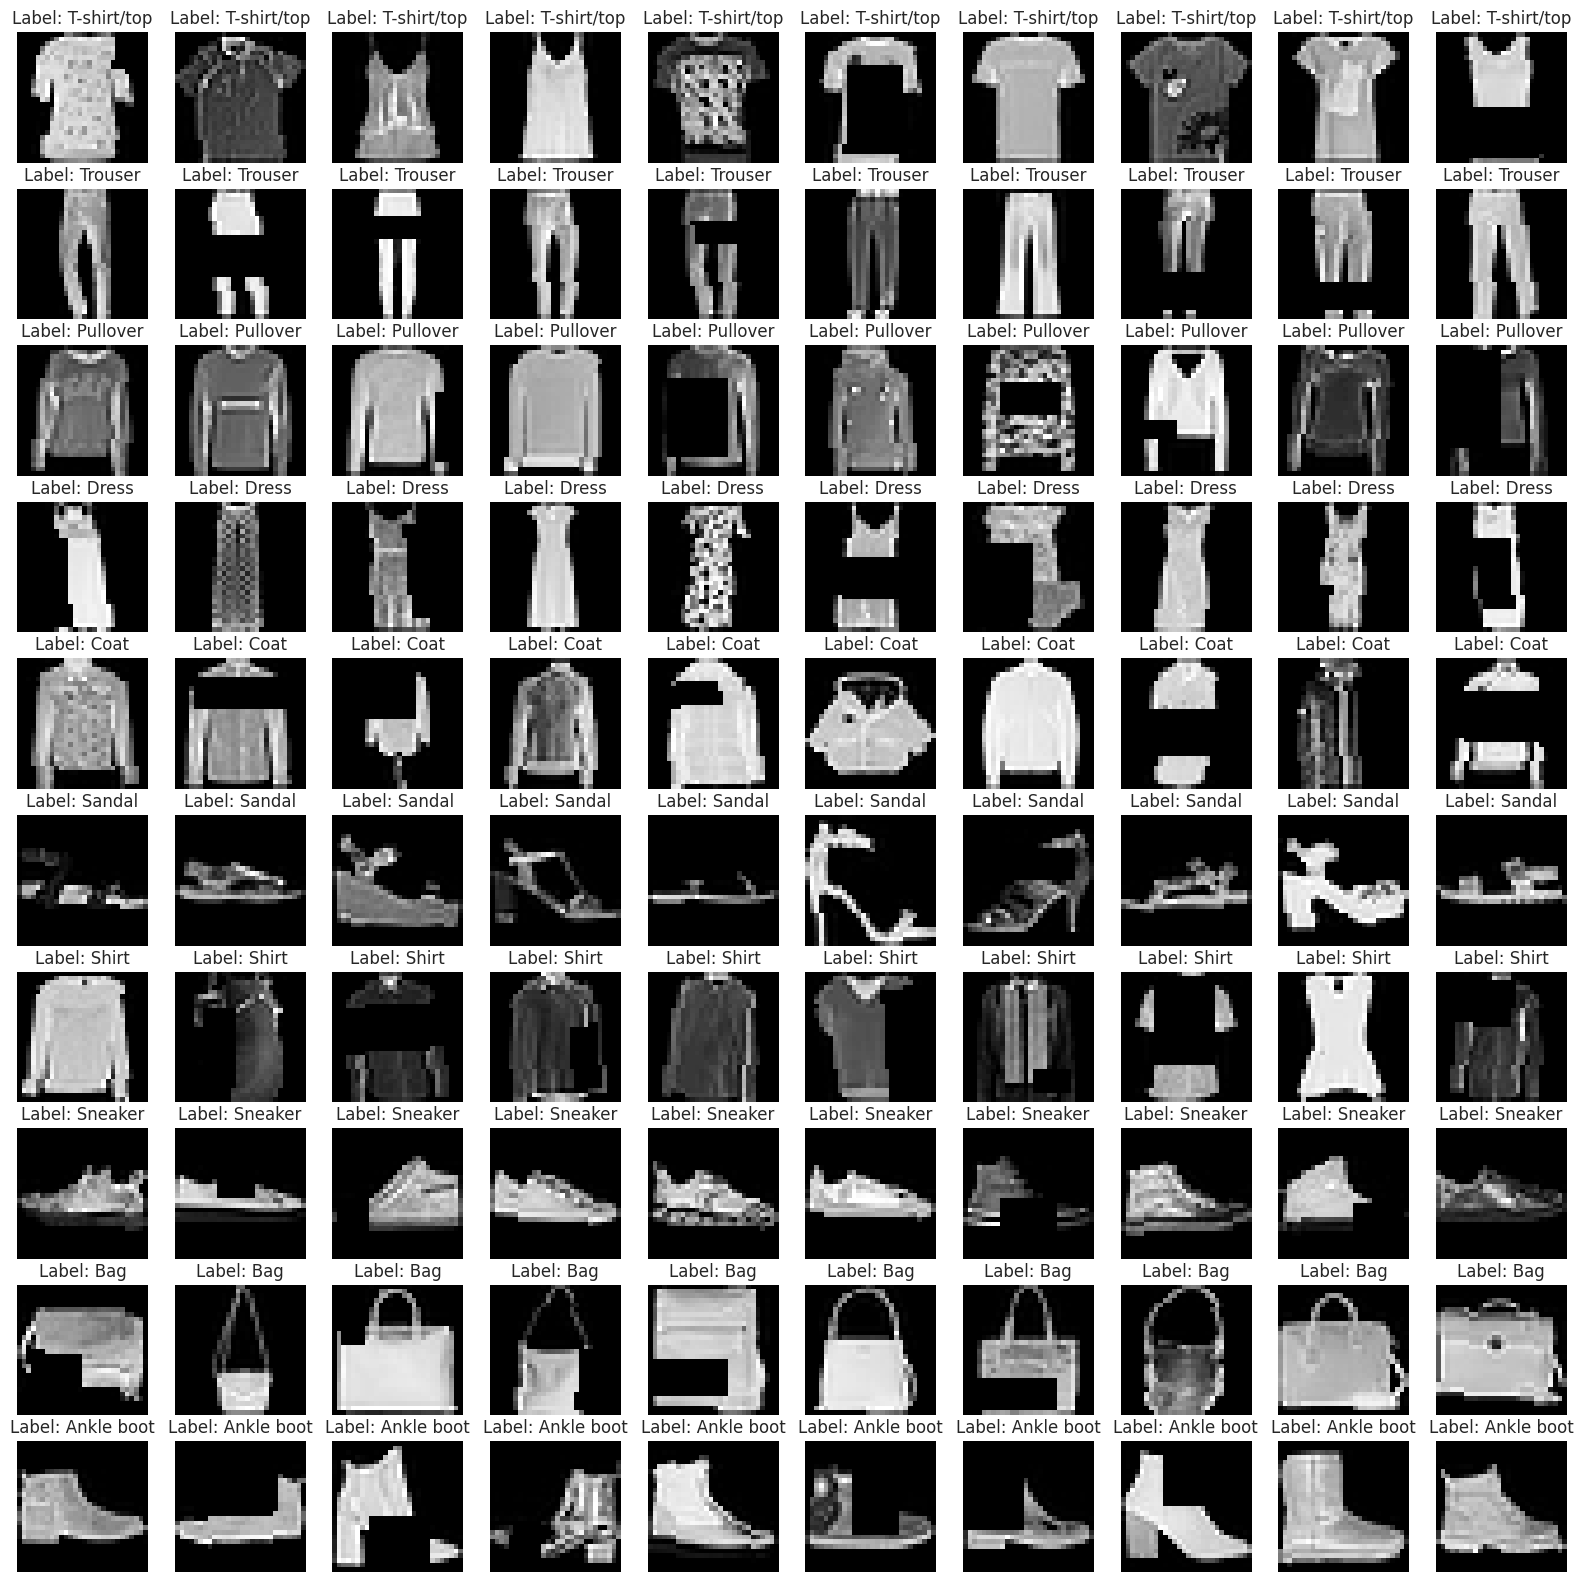

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
  images = trainset4_rep.reshape(-1,28,28)[np.squeeze(traindata_label.argmax(-1) == i)]
  random_idxs = np.random.choice(images.shape[0], 10, replace=False)
  images = images[random_idxs]
  label = class_labels[i]
  for j in range(10):
    subplot = ax[i, j]
    subplot.axis("off")
    subplot.imshow(images[j], cmap="gray")
    subplot.set_title(f"Label: {label}")
fig.show()

trainset6

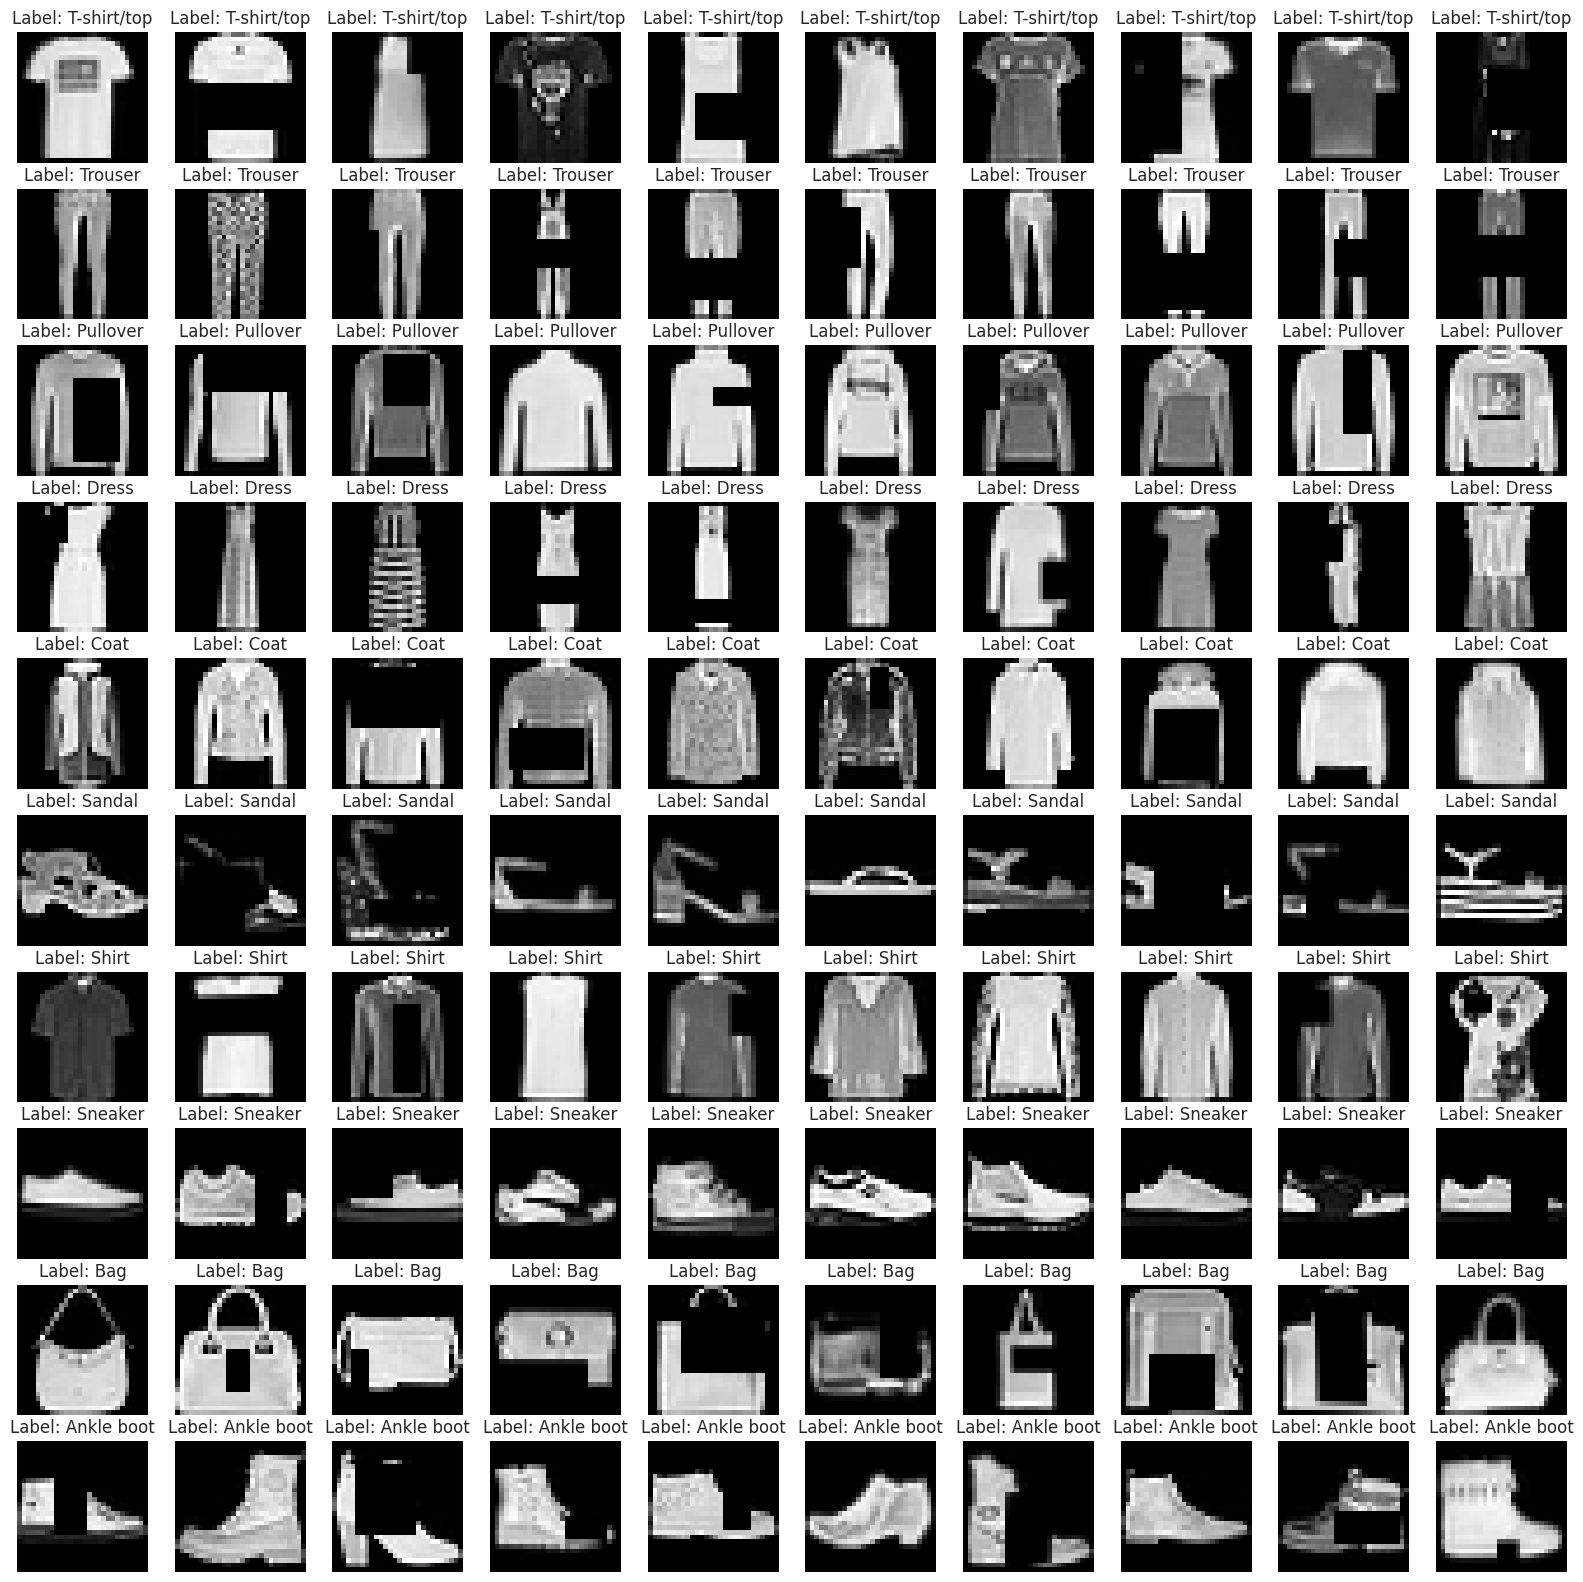

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
  images = trainset6_rep.reshape(-1,28,28)[np.squeeze(traindata_label.argmax(-1) == i)]
  random_idxs = np.random.choice(images.shape[0], 10, replace=False)
  images = images[random_idxs]
  label = class_labels[i]
  for j in range(10):
    subplot = ax[i, j]
    subplot.axis("off")
    subplot.imshow(images[j], cmap="gray")
    subplot.set_title(f"Label: {label}")
fig.show()

### Observations to point out:
I can tell that all the augmentation techniques are working. Random erasing is randoming random chunk of the data with different sizes, it is also sometimes shifting a part of the image. horizontal flip is also working as most of the shoes are now pointed to the right. The rotation is not so obvious but I can see some of the shoes being slightly more rotated than others, so rotation is also working. Lastly, RandomPrespective is also working since I can see some rotation and distortion when trainset6 is displayed.

So how has the 'average' replicated image of each class look like now?

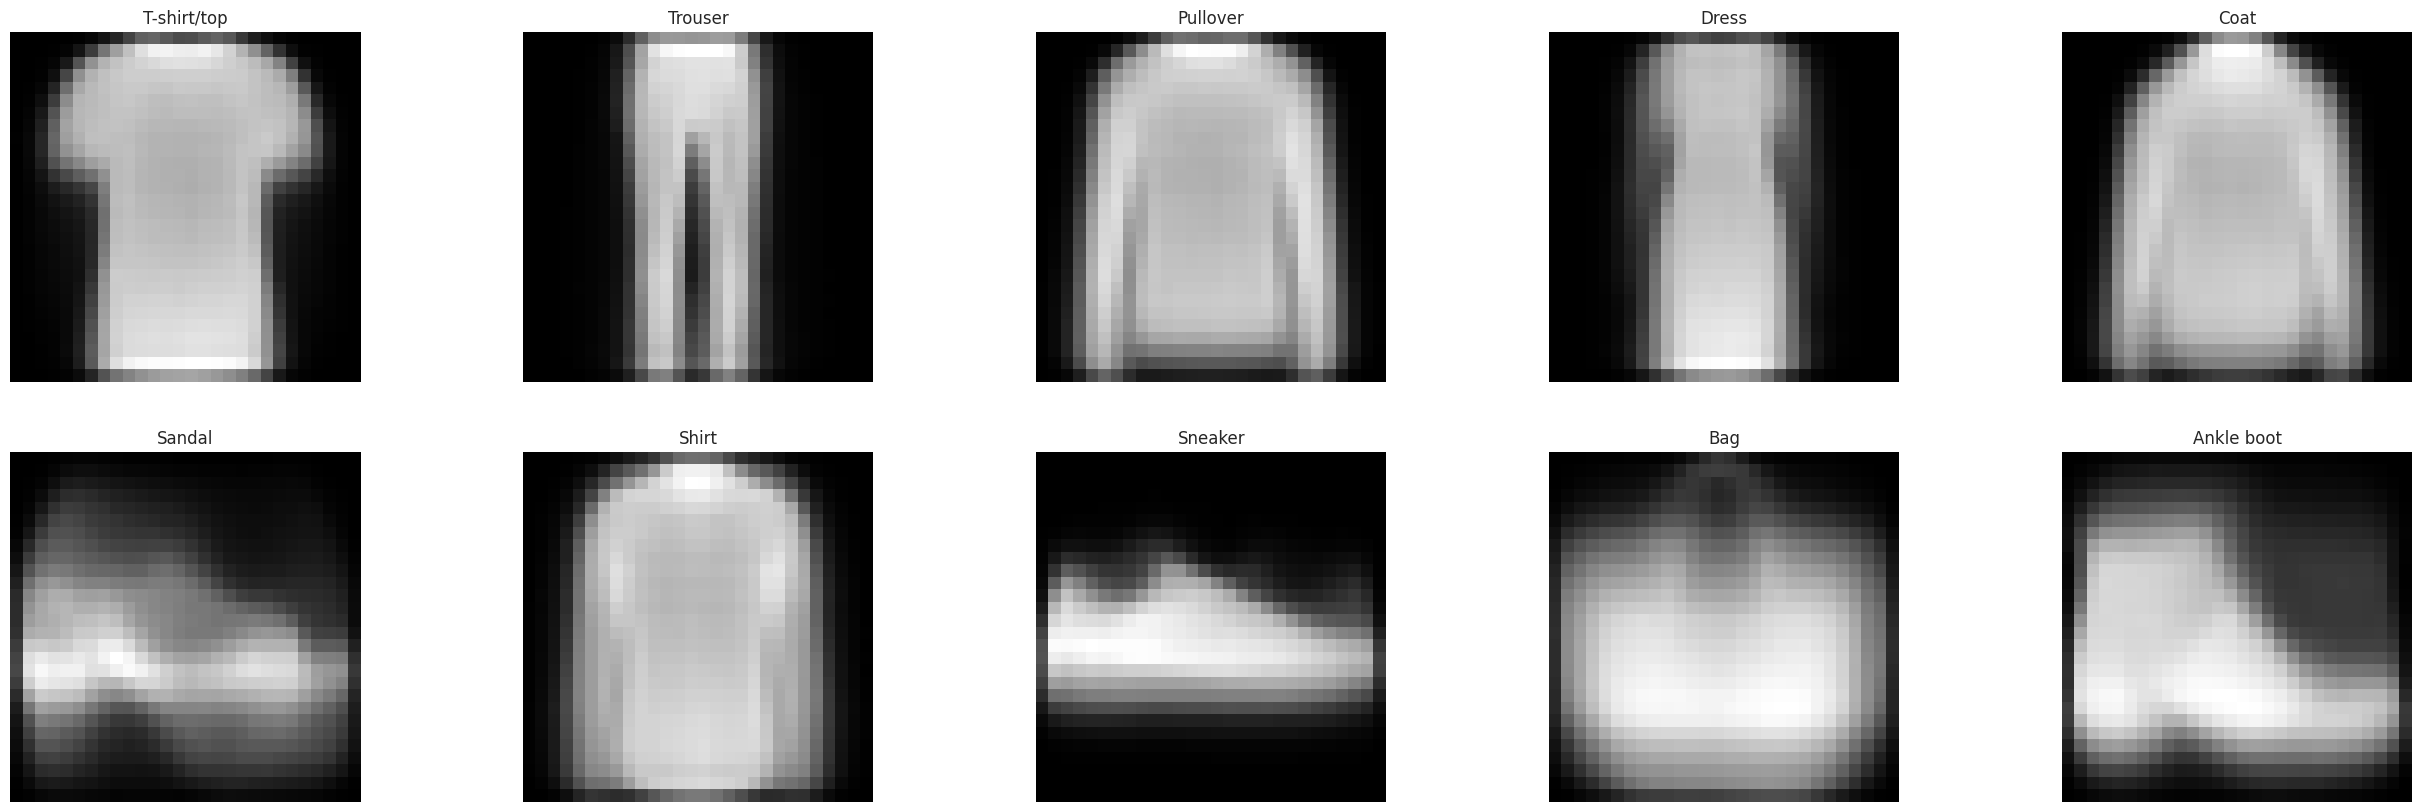

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(32, 10))
for idx, subplot in enumerate(ax.ravel()):
  avg_image = np.mean(trainset4_rep.reshape(-1,28,28).numpy()[np.squeeze(traindata_label.argmax(-1) == idx)], axis=0) / 255
  subplot.imshow(avg_image, cmap="gray")
  subplot.set_title(f"{class_labels[idx]}")
  subplot.axis("off")
del trainset4_rep, trainset6_rep

### Observations to point out:
The 'average' of the augmented data are generally blurrier, which is expected since more noise is introduced such as rotation, random erasing and even horizontal flip as seen by the shoes. Most shoes are now pointed the right direction instead of left which may be a problem for the model since our test data contain only shoes pointing left. However, with more shoes pointing right this may help increase the regularization effect and feature extraction capabilities. Model evaluation on different augmentation data is needed.

# 3.0) Modeling and Evaluation
Goals:
- Implementing my own convolutional network from scratch
- Looking into more advanced model architecture
- Evaluating different baseline models
- Ultility functions to help train, evaluate and keep track of my models

## 3.1) Ultility functions
- Loss & Accuracy Plotter: Function to plot the history between training and validation set to observe the rate of loss decrease or accuracy increase between training and validation set, this can help us look for outliers as well. It also indicates the point where validation loss & accuracy is the highest.
- Early Stopper: Used to track validation loss and accuracy. If validation loss or accuracy does not increase over N epochs, the model will stop training. This is to prevent overfitting of the training data.
- Model History Logger: A simple function to keep track of different models and their highest validation loss and accuracy. Easy to evaluate many different types of models.
- Train & Validate Function: A function to train & validation our model on training and validation sets

Loss & Accuracy Plotter:

In [ ]:
def plot_history(train_loss, train_acc, val_loss, val_acc, epoch_his,title):
    fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 6))
    sns.lineplot(x=epoch_his,y=train_loss, ax=ax1, label='Train Loss')
    sns.lineplot(x=epoch_his,y=val_loss, ax=ax1, label='Validation Loss')
    sns.lineplot(x=epoch_his,y=train_acc, ax=ax2, label='Train Accuracy')
    sns.lineplot(x=epoch_his,y=val_acc, ax=ax2, label='Test Accuracy')
    ax1.title.set_text(f'Lowest val loss @{min(val_loss):.4f} @Epoch {epoch_his[val_loss.index(min(val_loss))]}')
    ax2.title.set_text(f'Highest val acc @{max(val_acc):.4f} @Epoch {epoch_his[val_acc.index(max(val_acc))]}')
    ax1.axvline(epoch_his[val_loss.index(min(val_loss))],color='r',ls='--',alpha=0.75)
    ax2.axvline(epoch_his[val_acc.index(max(val_acc))],color='r',ls='--',alpha=0.75)
    ax1.axhline(min(val_loss),color='r',ls='--',alpha=0.75)
    ax2.axhline(max(val_acc),color='r',ls='--',alpha=0.75)
    fig.suptitle(title)
    plt.show()

Early Stopper Class: Init parameters take in patience (number of epochs of no improvement to validation loss & accuracy before stopping the model)

In [ ]:
class EarlyStopping():
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.early_stop = False
        self.lowest_val_loss = 99999999
        self.highest_val_accuracy = 0
    def __call__(self, val_acc, val_loss):
        if val_loss >= self.lowest_val_loss and val_acc <= self.highest_val_accuracy:
            self.counter +=1
        else:
            self.counter = 0
            if val_acc > self.highest_val_accuracy:
                self.highest_val_accuracy = val_acc
            if val_loss < self.lowest_val_loss:
                self.lowest_val_loss = val_loss
        if self.counter >= self.patience:  
            self.early_stop = True
        return self.early_stop
    def reset(self):
        self.counter = 0
        self.lowest_val_loss = 99999999
        self.highest_val_accuracy = 0
        self.early_stop = False

Model History Logger: Simple function to append informaton on the different models' highest validation loss & accuracy and lowest train loss

In [ ]:
def keep_history(df,train_acc,train_loss,val_loss, val_acc, epoch_his,model_desc='NIL',desc='NIL'):
    return pd.concat([df,pd.DataFrame([[min(val_loss),max(val_acc),min(train_loss),max(train_acc),epoch_his[val_acc.index(max(val_acc))],model_desc,desc]],columns=['Lowest Val Loss','Highest Val Acc','Lowest Train Loss','Highest Train Acc','Epoch (Highest Val Acc)', 'Model Description', 'Parameter'])])

hist_df = pd.DataFrame([],columns=['Lowest Val Loss','Highest Val Acc','Lowest Train Loss','Highest Train Acc','Epoch (Highest Val Acc)', 'Model Description', 'Parameter'])


Train & Validate Functions: Trains the model and return a history of train loss & accuracy as well as validation loss & accuracy.

In [ ]:
def train(model, loader, optimizer, NUM_EPOCHS, criterion, valloader=None,earlystopper=None,showEpoch=True,scheduler=None,displayEvery=1):
    train_loss_his = []
    train_accuracy_his = []
    val_loss_his = []
    val_accuracy_his = []
    epoch_his = []
    earlystopper.reset()
    model.train()
    for epoch in range(NUM_EPOCHS):
        t0 = time.time()
        total = 0
        correct = 0
        running_loss = 0.0
        for data in loader:
            img, label = data 
            img = img.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            # _, predicted = torch.max(outputs.data, 1)
            correct += (outputs.argmax(-1) == label.argmax(-1)).sum().item()
            total += label.size(0)
            running_loss += loss.item()
        if scheduler is not None:
            scheduler.step()
        accuracy = 100 * correct / total
        loss = running_loss / len(loader)
        train_loss_his.append(loss)
        train_accuracy_his.append(accuracy)
        val_loss, val_accuracy = validate(model, criterion, valloader)
        val_loss_his.append(val_loss)
        val_accuracy_his.append(val_accuracy)
        epoch_his.append(epoch+1)
        if showEpoch and (epoch+1)%displayEvery == 0:
            print(f'- [Epoch {epoch+1}/{NUM_EPOCHS}] | Train Loss: {loss:.3f}| Train Accuracy: {accuracy} | Val Loss: {val_loss:.3f} | Val Accuracy: {val_accuracy} | Est: {(time.time() - t0)*displayEvery:.2f}s')
        if earlyStopper(val_accuracy,val_loss):
            print(f'EarlyStopper triggered at epochs: {epoch+1} \n*No improvement to validation loss and accuracy could be seen for the past {earlyStopper.patience} epochs')
            break
    print(f'Highest Val Accuracy: {max(val_accuracy_his)}  @ epoch {epoch_his[val_accuracy_his.index(max(val_accuracy_his))]} | Lowest Val Loss: {min(val_loss_his)}  @ epoch {epoch_his[val_loss_his.index(min(val_loss_his))]}')
    return train_loss_his, train_accuracy_his, val_loss_his, val_accuracy_his,epoch_his
 
def validate(model, criterion, loader=None):                     
    correct = 0                                               
    total = 0
    running_loss = []
    model.eval()
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # _, predicted = torch.max(outputs.data, 1)
        correct += (outputs.argmax(-1) == labels.argmax(-1)).sum().item()
        running_loss.append(loss.item())
        total += labels.size(0)
    mean_val_accuracy = (100 * correct / total)
    mean_val_loss = sum(running_loss) / len(running_loss)
    model.train()
    return mean_val_loss, mean_val_accuracy

## 3.2) Modelling
Goal is to make a few models and evaluate them eventually and use it for hyperparameter tuning<br><br>
- A baseline model from scratch, perhaps just 3 different types of model. (simple, slightly more complex, complex)
- Explore other model architectures that has been successful in the past. How can I modify these model to better fit my dataset?


### 3.2.1) Simple baseline models from scratch (collaspe or skip pass this section if its too long).
<br>

Layers inspired by the VGG16 architecture [[VGG16 Architecture](https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/)]
<br>
VGGNet16 is relatively simple and this 3 model architecture is inspired by it. However, the original VGGNet lacks batch normalization, which is proven to improve model generalization and batch normalization also provide slight regularization affect (this affect is lower if batch size is larger [because it has more samples each batch to normalize on]) [[Sergey Ioffe, 2015](https://arxiv.org/abs/1502.03167)]. Hence, batch normalization will be used

<br>

Each Conv2d for feature extraction part will follow a generic pattern:<br>
<u>Conv2d3x3</u> -> BatchNorm2d -> ReLU -> MaxPool2d
<br><br>
Classification (Fully connected layer):
Linear(Dropout-0.5) -> BatchNorm1d -> ReLU

#### 3.2.1.1) SimpleNet1
- 2 Blocks of layers
- Less complex

In [ ]:
def simpleBlock(inp_channel, layers, maxpoolStride1 = False):
    block = nn.Sequential()
    for i in range(layers-1):
        block.add_module(f'conv_layer_{i+1}', nn.Conv2d(inp_channel, inp_channel,kernel_size=3,stride=1,padding=1))
        block.add_module(f'batch_norm_{i+1}',nn.BatchNorm2d(inp_channel))
        block.add_module(f'ReLU_{i+1}',nn.ReLU(inplace=True))
    if layers-1 > 0 and not maxpoolStride1:
        block.add_module('max_pool2x2',nn.MaxPool2d(2, 2))
    elif layers-1 > 0 and maxpoolStride1:
        block.add_module('max_pool2x2',nn.MaxPool2d(2, 1))
    return block


class SimpleNet1(nn.Module):
    def __init__(self,layer_config,inp,out,growthRate=2,fc_neurons=256):
        super(SimpleNet1, self).__init__()
        # Implement the sequential module for feature extraction
        self.start = nn.Sequential(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))

        #Expand
        inp = out
        out = out * growthRate

        self.block1 = simpleBlock(inp,layer_config[0])


        self.block2 = nn.Sequential(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.block2_add = simpleBlock(out, layer_config[1])

        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(out * 7 * 7, fc_neurons), nn.BatchNorm1d(fc_neurons), nn.ReLU(inplace=True), nn.Dropout(p=0.5),
            nn.Linear(fc_neurons, fc_neurons), nn.BatchNorm1d(fc_neurons), nn.ReLU(inplace=True),
            nn.Linear(fc_neurons, 10)
            )
        # CrossEntropyLoss already have softmax activation
    def forward(self, x):
    	# Features extraction
        x = self.start(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block2_add(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

#### 3.2.1.2) SimpleNet2
- 3 Blocks of layers
- More complex

In [ ]:
class SimpleNet2(nn.Module):
    def __init__(self,layer_config,inp,out,growthRate=2,fc_neurons=512):
        super(SimpleNet2, self).__init__()
        # Implement the sequential module for feature extraction
        self.start = nn.Sequential(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        inp = out
        out = out * growthRate
        self.block1 = simpleBlock(inp,layer_config[0],True)
        self.block2 = nn.Sequential(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.block2_add = simpleBlock(out, layer_config[1])
        #Expand
        inp = out
        out = out * growthRate
        self.block3 = nn.Sequential(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.block3_add = simpleBlock(out, layer_config[2])
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(out * 6 * 6, fc_neurons), nn.BatchNorm1d(fc_neurons), nn.ReLU(inplace=True), nn.Dropout(p=0.5),
            nn.Linear(fc_neurons, fc_neurons), nn.BatchNorm1d(fc_neurons), nn.ReLU(inplace=True),
            nn.Linear(fc_neurons, 10)
            )
        # CrossEntropyLoss already have softmax activation
    def forward(self, x):
    	# Features extraction
        x = self.start(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block2_add(x)
        x = self.block3(x)
        x = self.block3_add(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

#### 3.2.1.3) SimpleNet3
- 4 Blocks of layers
- Most complex

In [ ]:
class SimpleNet3(nn.Module):
    def __init__(self,layer_config,inp,out,growthRate=2,fc_neurons=1024):
        super(SimpleNet3, self).__init__()
        # Implement the sequential module for feature extraction
        self.start = nn.Sequential(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=5, stride=1, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        inp = out
        out = out * growthRate
        self.block1 = simpleBlock(inp,layer_config[0])
        self.block2 = nn.Sequential(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.block2_add = simpleBlock(out, layer_config[1])
        #Expand
        inp = out
        out = out * growthRate
        self.block3 = nn.Sequential(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.block3_add = simpleBlock(out, layer_config[2])
        #Expand
        inp = out
        out = out * growthRate
        self.block4 = nn.Sequential(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.block4_add = simpleBlock(out, layer_config[3], True)
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(out *2 * 2, fc_neurons), nn.BatchNorm1d(fc_neurons), nn.ReLU(inplace=True), nn.Dropout(p=0.5),
            nn.Linear(fc_neurons, fc_neurons), nn.BatchNorm1d(fc_neurons), nn.ReLU(inplace=True),
            nn.Linear(fc_neurons, 10)
            )
        # CrossEntropyLoss already have softmax activation
    def forward(self, x):
    	# Features extraction
        x = self.start(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block2_add(x)
        x = self.block3(x)
        x = self.block3_add(x)
        x = self.block4(x)
        x = self.block4_add(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

### 3.2.2) ResNet
ResNet also known as residual network present a residual learning framework to ease the training of networks that are substantially deeper than those used previously back in 2015. It was 8x deeper than VGG nets which was considered one of the state-of-the-art architect during that period. ResNet achieved a state-of-the-art performance winning 1st place in ILSVRC 2015 with an error rate of 3.57% on ImageNet (Top 5) [[He et al., 2015](https://arxiv.org/abs/1512.03385)].<br><br>
Skip connections or shortcuts from a residual block are used to jump over some layers to the next residual block then implementing some 'residual' into the new layer thus overcoming the problem with vanishing graident.

Types of modification to see: The original ResNet152 was built for ImageNet which has 1.2 million training images and 1000 classifications, but our assignment only has 70,000 and 10 classification. Thus, I will again make 3 custom ResNet models of differenting layers, neurons and complexity the original models may be too complex for our current dataset.

Code to initilize the ResNet, from original source code: [[ResNet PyTorch - Github](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)] <br>

Edits made to original source code by:
- Removing weights
- Removing pre-made models
- Changing variable names to make sure it work as a custom ResNet
- Building models from scratch but making use of their architecture
- 7x7 first conv kernel -> 5x5 kernel

In [ ]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    # 3x3 convolution with padding
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 10,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=5, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

Custom ResNet (3 Blocks): The original ResNet architecture contain 4 blocks. However, since we are using a simplier dataset I will create a ResNet archietecture with 3 blocks to reduce its complexity.
- Code is referenced but all comments are original and done based on my understanding of the code and network

In [ ]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        # 2D 1x1 conv layer
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        # input = output filters (3x3 conv)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        # Batch normalization
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        # This layer will expand the number of filters used (1x1 conv)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        # Downsample (this identity is used as a residual when skipping connections)
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        # If this is the connection that is skipped to use identity
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        # Add residual (identity) to connection (if exist)
        x += identity
        x = self.relu(x)
        return x

# ResNet initializing
class ResNet3Blocks(nn.Module):
    def __init__(self, block, layers, image_channels = 1, num_classes = 10):
        super(ResNet3Blocks, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=5, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the 3 main layers/blocks of the network
        # See below for _make_layer code and comments
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * 4, num_classes)
    # Make the layer of ResNet
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Code to change input space for identity so it will be able to be added to the layer
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # Finally adding the rest of the layers
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        # Return all the layers
        return nn.Sequential(*layers)

    # Forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

Custom ResNet3Blocks class parameter goes as follow ResNet(Bottleneck, _block configuration_)
- _block configuration_: Number of sets of conv layers to add for the block ex. [2,6,3]
- _input num_: Number of input channels
- _output num_: Number of values/classes to output


### 3.2.3) DenseNet [[Huang et al, 2016](https://arxiv.org/abs/1608.06993v5)]

DenseNet is similar to ResNet where its residual is also passed down as it goes down the layers but what makes DenseNet different from ResNet would be the connectivity pattern of its residual. What does this mean?<br><br>

<img src="https://i.imgur.com/z3n0Afg.png" width="750" alt='DenseNet_ResNet comparision'>

<br>

Basically the idea behind DenseNet is that the input of the next layer is a combination of the input and residual from <b><u>all</u></b> the pervious layers combined.

<br>

This connectivity pattern has shown improvements over ResNet architecture.

Code referenced from https://github.com/pytorch/vision/blob/main/torchvision/models/densenet.py <br><br>
Edits made to original source code by:
- Modified to fit 1 channel input (original takes in 3 channels)<br>

Greatly reduced the original source code by:
- Removing weights
- Removing pre-made models
- Changing variable names to make sure it work as a custom DenseNet
- Building models from scratch, but making use of their architecture
- 7x7 first conv kernel -> 5x5 kernel

In [ ]:
class _DenseLayer(nn.Module):
    def __init__(
        self, num_input_features: int, growth_rate: int, bn_size: int, drop_rate: float, memory_efficient: bool = False
    ) -> None:
        super().__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)

        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[torch.Tensor]) -> torch.Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[torch.Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[torch.Tensor]) -> torch.Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[torch.Tensor]) -> torch.Tensor:  # noqa: F811
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: torch.Tensor) -> torch.Tensor:  # noqa: F811
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: torch.Tensor) -> torch.Tensor:  # noqa: F811
        if isinstance(input, torch.Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False,
    ) -> None:
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module("denselayer%d" % (i + 1), layer)

    def forward(self, init_features: torch.Tensor) -> torch.Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super().__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)


class DenseNet(nn.Module):
    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 10,
        memory_efficient: bool = False,
    ) -> None:

        super().__init__()

        # First convolution
        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(1, num_init_features, kernel_size=5, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.features.add_module("denseblock%d" % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module("transition%d" % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module("norm5", nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

Parameters for DenseNet code above (based on my understanding of this code):<br>
DenseNet(_growthrate_, (_block configuration_), _output_)<br>
- _growthrate_ is the increment of filters from one block to another block<br>
- _block configuration_ is the set of conv layers in each block<br>
- _output_ is the number of values/classes you'd wish to output.

DenseNet will be the last architecture I will be exploring in Part A

## 3.3) Initilization of Models
- Different Baseline Models will be initilized here and evaluated
- Evaluation will be done with (trainset1 - min-max normalized dataset)
- During model improvement different types of augmented datasets will be tested

### 3.3.1) Evaluation Preparation

Early Stopper set to 18

In [ ]:
# init early stopper with patience of 18
earlyStopper = EarlyStopping(18)

Loading validation and trainset1 (min-max normalized dataset)

In [ ]:
trainloader1 = DataLoader(TensorDataset(trainset1.type('torch.FloatTensor'),traindata_label.type('torch.FloatTensor')), shuffle=True, batch_size=BATCH_SIZE)
valloader = DataLoader(TensorDataset(valset.type('torch.FloatTensor'),valdata_label.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)

### 3.3.2) Model summaries & initilizing different types of model architectures
- My own basic architecture similar to a VGGNet (will be trying 3 different complexity models ranging from 2-4 Blocks)
- Custom ResNet (4 Residual Blocks)
- Custom ResNet (3 Blocks instead of 4)
- Custom DenseNet (4 Dense Blocks)
- Custom DenseNet (3 Blocks instead of 4)

In [ ]:
OwnBaseline1 = SimpleNet1([2,2],1,32,2,256)
print('OwnBaseline1')
summary(OwnBaseline1,(1,28,28))

OwnBaseline2 = SimpleNet2([2,2,2],1,32,2,512)
print('\nOwnBaseline2')
summary(OwnBaseline2,(1,28,28))

print('\nOwnBaseline3')
OwnBaseline3 = SimpleNet3([2,3,4,4],1,32,2,1024)
summary(OwnBaseline3,(1,28,28))


ResNet4Blocks = ResNet(Bottleneck,[1,1,1,1])
print('\nResNet4Blocks')
summary(ResNet4Blocks,(1,28,28))

ResNet3Blocks = ResNet3Blocks(block,[1,2,1],1,10)
print('\nResNet3Blocks')
summary(ResNet3Blocks,(1,28,28))


DenseNet4Blocks = DenseNet(24,(3,6,12,8),10)
print('\nDenseNet4Blocks')
summary(DenseNet4Blocks,(1,28,28))

DenseNet3Blocks = DenseNet(16,(8,20,15),10)
print('\nDenseNet3Blocks')
summary(DenseNet3Blocks,(1,28,28))

From the above summaries I will give each baseline model an alies and compile the numbers of parameters they all have.
<br>

| Model | Layers (Conv+FC) | Parameters |
|---|---|---|
| OwnBaseline1 | 7  | 937,834 |
| OwnBaseline2 | 9  | 2,917,482 |
| OwnBaseline3 |  16   | 4,801,578 |
| ResNet4Blocks |  14   | 8,028,618 |
| ResNet3Blocks |  14   | 2,258,890 |
| DenseNet4Blocks |  93   | 1,253,276 |
| DenseNet3Blocks |  93   | 1,122,830 |

<br>

Off the bat, I can tell that the DenseNet architecture has more layers than the rest but it is not surprising as DenseNet scale up by increasing its depth, something good to explore would be EfficientNet's compound scaling.

Initializing criterion
- Cross entropy loss will be used as our criterion. Cross entropy loss is a metric used to measure how well a classification model in machine learning performs. The loss lower the loss the better the model performs, 0 being the lowest.

In [ ]:
criterion = nn.CrossEntropyLoss()

## 3.4) Model Training
- Which model should I use for my model improvement/hypertuning
- For now, I will use Adam with weights as my optimizer as it is a lot more efficient than SGD, even though there are many research stating that SGD generalizes better than Adam but as for model training I want to train my model as quickly as possible [[Keskar et al., 2017](https://arxiv.org/abs/1712.07628)], [[Lightly, 2020](https://www.lightly.ai/post/which-optimizer-should-i-use-for-my-machine-learning-project)]. Perhaps for model improvement I will optimizers for hyperparameter tuning. **TLDR; SGD better but Adam more efficient, so I use Adam for now**
- 2 generic learning rate, which is slow and fast will be chosen for now
- A maximum of 80 epochs will be given to each model

A simple function to reduce repetition of code...

In [ ]:
def _train(model,model_desc,parameters_desc,fast=True,showEpochs = True,trainloader = trainloader1, df = hist_df,displayEvery=10):
    global hist_df
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        model = model.to(device)
    else:
        model = model.to(device)
    if fast:
        optimizer = optim.AdamW(model.parameters(),lr=0.008, weight_decay=0.1)
    else:
        optimizer = optim.AdamW(model.parameters(),lr=0.004, weight_decay=0.01)
    train_loss, train_acc, val_loss, val_acc, epoch_his = train(model,trainloader,optimizer,80,criterion,valloader,earlyStopper,showEpochs,displayEvery=displayEvery)
    df = keep_history(df,train_acc,train_loss, val_loss, val_acc, epoch_his,model_desc,parameters_desc)
    return train_loss, train_acc, val_loss, val_acc, epoch_his, df

### 3.4.1) Own Baseline Model Training
- OwnBaseline1: 7 Layers - 937,834 Parameters
- OwnBaseline2: 11 Layers - 2,917,482 Parameters
- OwnBaseline3: 14 Layers - 4,801,578 Parameters
<br><br>

*It may be rather annoying to show all the epochs for all models...so I will only display accuracy/loss every 10th epoch*

Training of OwnBaselines (VGGNet inspired)

In [ ]:
print('OwnBaseline1')
train_loss1, train_acc1, val_loss1, val_acc1, epoch_his1, hist_df = _train(OwnBaseline1,'OwnBaseline1','937,834',False,df=hist_df)
print('\nOwnBaseline2')
train_loss2, train_acc2, val_loss2, val_acc2, epoch_his2, hist_df = _train(OwnBaseline2,'OwnBaseline2','2,917,482', False,df=hist_df)
print('\nOwnBaseline3')
train_loss3, train_acc3, val_loss3, val_acc3, epoch_his3, hist_df = _train(OwnBaseline3,'OwnBaseline3','4,801,578',df=hist_df)

OwnBaseline1
- [Epoch 10/80] | Train Loss: 0.170| Train Accuracy: 93.74 | Val Loss: 0.195 | Val Accuracy: 93.17 | Est: 29.29s
- [Epoch 20/80] | Train Loss: 0.119| Train Accuracy: 95.65 | Val Loss: 0.191 | Val Accuracy: 93.34 | Est: 27.70s
- [Epoch 30/80] | Train Loss: 0.090| Train Accuracy: 96.62 | Val Loss: 0.189 | Val Accuracy: 94.17 | Est: 27.99s
- [Epoch 40/80] | Train Loss: 0.073| Train Accuracy: 97.258 | Val Loss: 0.216 | Val Accuracy: 93.46 | Est: 29.27s
- [Epoch 50/80] | Train Loss: 0.059| Train Accuracy: 97.87 | Val Loss: 0.221 | Val Accuracy: 93.78 | Est: 27.11s
EarlyStopper triggered at epochs: 53 
*No improvement to validation loss and accuracy could be seen for the past 18 epochs
Highest Val Accuracy: 94.32  @ epoch 35 | Lowest Val Loss: 0.17969967871904374  @ epoch 16

OwnBaseline2
- [Epoch 10/80] | Train Loss: 0.153| Train Accuracy: 94.346 | Val Loss: 0.204 | Val Accuracy: 92.53 | Est: 44.54s
- [Epoch 20/80] | Train Loss: 0.093| Train Accuracy: 96.532 | Val Loss: 0.219 |

### 3.4.2) Custom ResNet Baseline Training
- ResNet4Blocks: 14 Layers - 8,028,618 Parameters
- ResNet3Blocks: 13 Layers - 2,258,890 Parameters

In [ ]:
print('ResNet4Blocks')
train_loss4, train_acc4, val_loss4, val_acc4, epoch_his4, hist_df = _train(ResNet4Blocks,'ResNet4Blocks','8,028,618',df=hist_df)
print('\nResNet3Blocks')
train_loss5, train_acc5, val_loss5, val_acc5, epoch_his5, hist_df = _train(ResNet3Blocks,'ResNet3Blocks','2,258,890',False,df=hist_df)

ResNet4Blocks
- [Epoch 10/80] | Train Loss: 0.188| Train Accuracy: 93.0 | Val Loss: 0.323 | Val Accuracy: 89.02 | Est: 42.69s
- [Epoch 20/80] | Train Loss: 0.132| Train Accuracy: 94.948 | Val Loss: 0.293 | Val Accuracy: 90.65 | Est: 42.68s
- [Epoch 30/80] | Train Loss: 0.086| Train Accuracy: 96.754 | Val Loss: 0.343 | Val Accuracy: 89.39 | Est: 43.59s
- [Epoch 40/80] | Train Loss: 0.061| Train Accuracy: 97.724 | Val Loss: 0.367 | Val Accuracy: 90.9 | Est: 42.57s
EarlyStopper triggered at epochs: 40 
*No improvement to validation loss and accuracy could be seen for the past 18 epochs
Highest Val Accuracy: 91.33  @ epoch 22 | Lowest Val Loss: 0.24965646266937255  @ epoch 16

ResNet3Blocks
- [Epoch 10/80] | Train Loss: 0.124| Train Accuracy: 95.376 | Val Loss: 0.301 | Val Accuracy: 90.37 | Est: 39.05s
- [Epoch 20/80] | Train Loss: 0.055| Train Accuracy: 97.922 | Val Loss: 0.376 | Val Accuracy: 91.07 | Est: 38.34s
- [Epoch 30/80] | Train Loss: 0.024| Train Accuracy: 99.12 | Val Loss: 0.483

### 3.4.3) Custom DenseNet Baseline Training
- DenseNet4Blocks: 93 Layers - 1,253,276 Parameters
- DenseNet3Blocks: 93 Layers - 1,122,830 Parameters

In [ ]:
print('DenseNet4Blocks')
train_loss6, train_acc6, val_loss6, val_acc6, epoch_his6, hist_df = _train(DenseNet4Blocks,'DenseNet4Blocks','1,253,276',False,df=hist_df)
print('DenseNet3Blocks')
train_loss7, train_acc7, val_loss7, val_acc7, epoch_his7, hist_df = _train(DenseNet3Blocks,'DenseNet3Blocks','1,122,830',False,df=hist_df)

DenseNet4Blocks
- [Epoch 10/80] | Train Loss: 0.168| Train Accuracy: 93.736 | Val Loss: 0.316 | Val Accuracy: 88.89 | Est: 88.69s
- [Epoch 20/80] | Train Loss: 0.079| Train Accuracy: 97.014 | Val Loss: 0.400 | Val Accuracy: 88.35 | Est: 88.31s
- [Epoch 30/80] | Train Loss: 0.048| Train Accuracy: 98.188 | Val Loss: 0.486 | Val Accuracy: 89.05 | Est: 89.72s
- [Epoch 40/80] | Train Loss: 0.026| Train Accuracy: 99.024 | Val Loss: 0.536 | Val Accuracy: 89.53 | Est: 87.70s
- [Epoch 50/80] | Train Loss: 0.016| Train Accuracy: 99.456 | Val Loss: 0.623 | Val Accuracy: 89.23 | Est: 88.20s
EarlyStopper triggered at epochs: 54 
*No improvement to validation loss and accuracy could be seen for the past 18 epochs
Highest Val Accuracy: 90.11  @ epoch 36 | Lowest Val Loss: 0.3052383542060852  @ epoch 9
DenseNet3Blocks
- [Epoch 10/80] | Train Loss: 0.165| Train Accuracy: 93.874 | Val Loss: 0.296 | Val Accuracy: 89.87 | Est: 122.05s
- [Epoch 20/80] | Train Loss: 0.069| Train Accuracy: 97.556 | Val Loss:

## 3.5) Model Evaluation (1)
- Which baseline model should be used for model improvements/hypertuning?
- What are the characteristics of the simpler/complex model

In [ ]:
def classification_rep(model,criterion,loader,train_loss, train_acc, val_loss, val_acc, epoch_his ,title, plot=True):
    print(title)
    if plot:
        plot_history(train_loss, train_acc, val_loss, val_acc, epoch_his,title)
    y_pred = []                                   
    y_true = []
    model.eval()
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        y_pred.extend(outputs.argmax(-1).tolist())
        y_true.extend(labels.argmax(-1).tolist())
    model.train()
    print(classification_report(y_true, y_pred,target_names=class_labels))
    s = sns.heatmap(confusion_matrix(y_true, y_pred), cmap='Blues', annot=True, fmt='d',
        xticklabels=class_labels,
        yticklabels=class_labels)
    s.set_xlabel('Predicted', fontsize=16)
    s.set_ylabel('Actual', fontsize=16)
    plt.show()
    return

### 3.5.1) Model evaluation of OwnBaseline models
- OwnBaseline1
- OwnBaseline2
- OwnBaseline3

,Lowest Val Loss,Highest Val Acc,Lowest Train Loss,Highest Train Acc,Epoch (Highest Val Acc),Model Description,Parameter
0,0.179700,94.32,0.054980,98.004,35,OwnBaseline1,"937,834"
0,0.172123,94.68,0.028777,98.968,35,OwnBaseline2,"2,917,482"
0,0.245260,92.57,0.053536,98.206,40,OwnBaseline3,"4,801,578"


OwnBaseline1


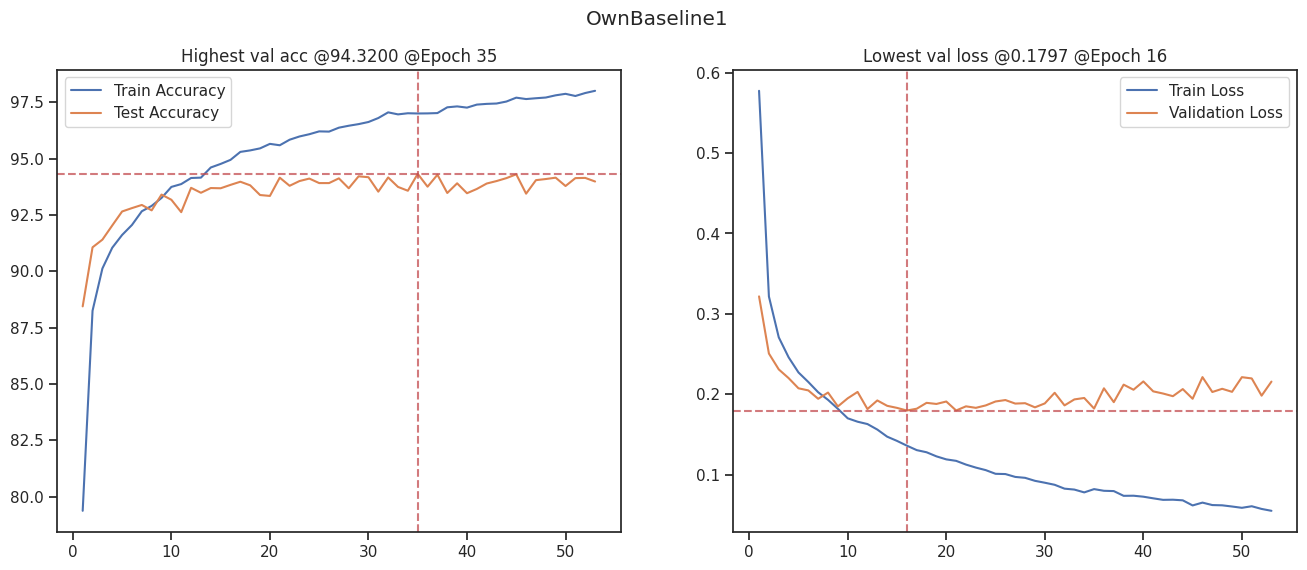

              precision    recall  f1-score   support

 T_shirt/top       0.91      0.86      0.89      1001
     Trouser       1.00      0.99      0.99       996
    Pullover       0.92      0.91      0.92      1004
       Dress       0.95      0.92      0.93      1017
        Coat       0.90      0.92      0.91       997
      Sandal       0.99      0.99      0.99       971
       Shirt       0.80      0.87      0.83       986
     Sneaker       0.98      0.97      0.97      1003
         Bag       0.98      0.99      0.99      1017
  Ankle boot       0.97      0.98      0.98      1008

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



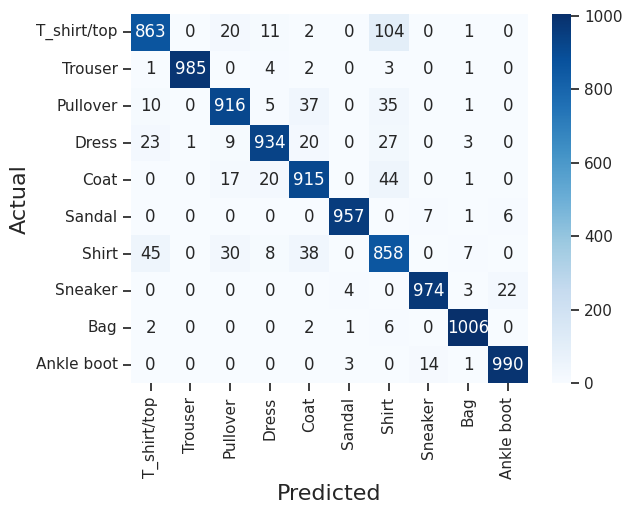

OwnBaseline2


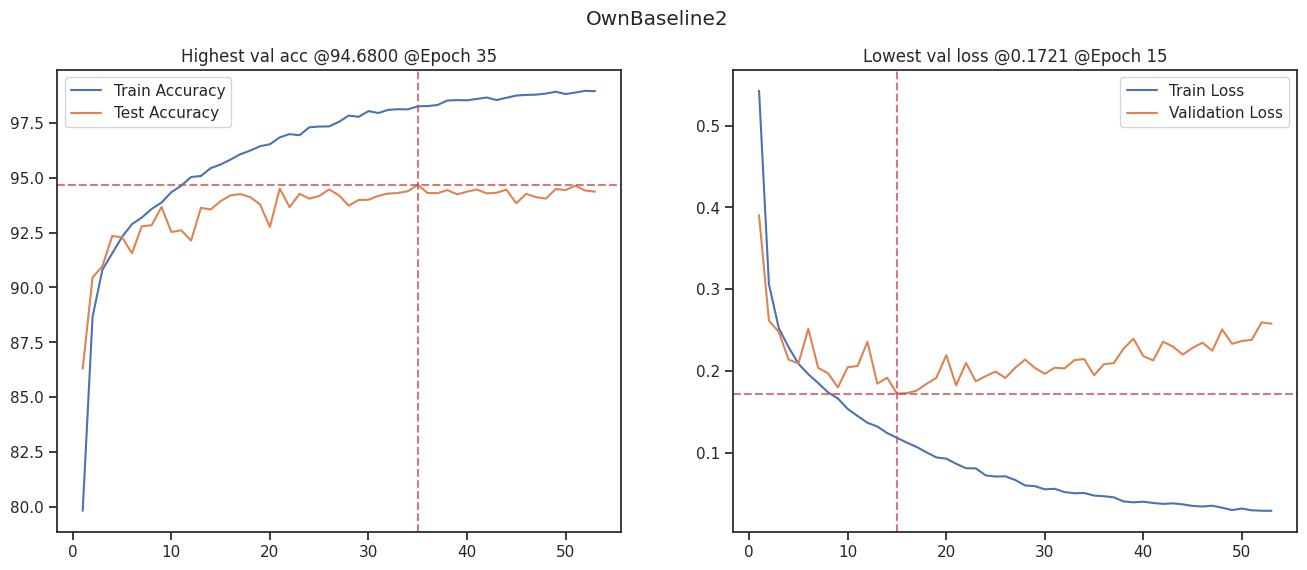

              precision    recall  f1-score   support

 T_shirt/top       0.89      0.93      0.91      1001
     Trouser       1.00      0.99      0.99       996
    Pullover       0.92      0.92      0.92      1004
       Dress       0.93      0.95      0.94      1017
        Coat       0.88      0.92      0.90       997
      Sandal       0.99      0.99      0.99       971
       Shirt       0.89      0.79      0.84       986
     Sneaker       0.96      0.99      0.98      1003
         Bag       0.99      0.99      0.99      1017
  Ankle boot       0.99      0.96      0.98      1008

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



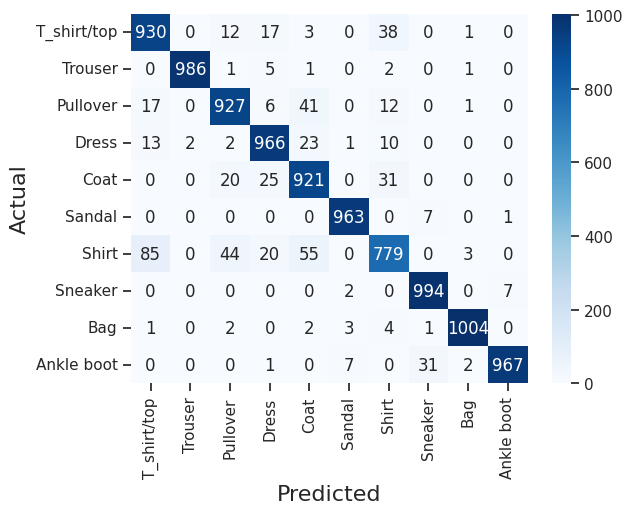

OwnBaseline3


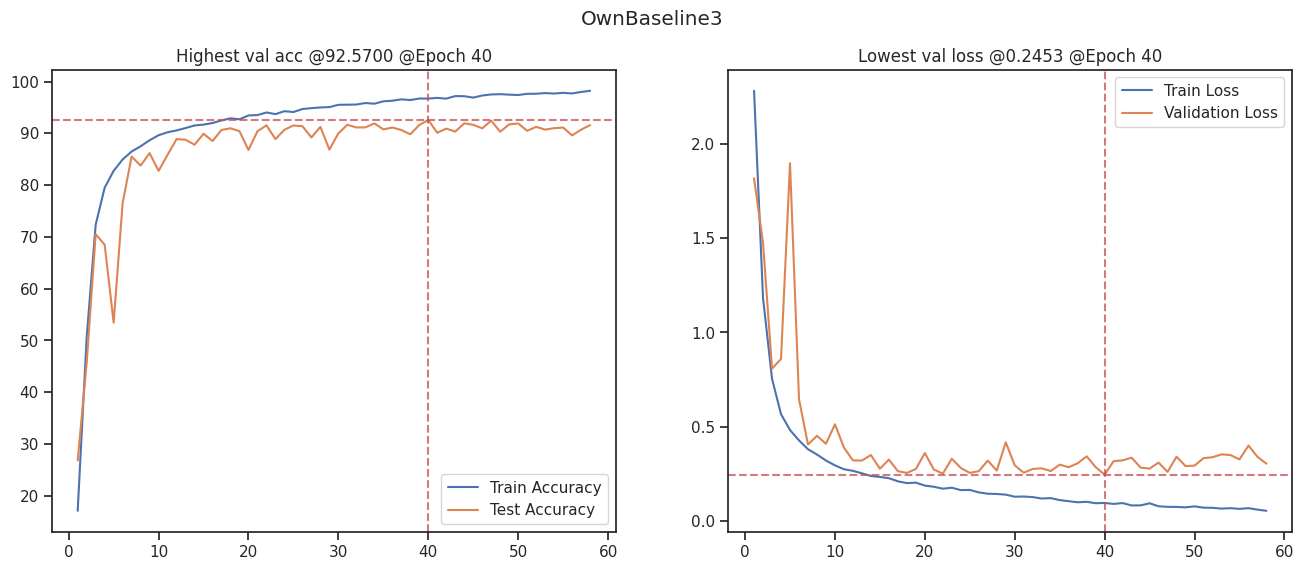

              precision    recall  f1-score   support

 T_shirt/top       0.91      0.80      0.85      1001
     Trouser       1.00      0.97      0.99       996
    Pullover       0.91      0.86      0.88      1004
       Dress       0.92      0.91      0.92      1017
        Coat       0.84      0.87      0.86       997
      Sandal       0.98      0.98      0.98       971
       Shirt       0.71      0.85      0.77       986
     Sneaker       0.96      0.97      0.97      1003
         Bag       0.99      0.97      0.98      1017
  Ankle boot       0.97      0.97      0.97      1008

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



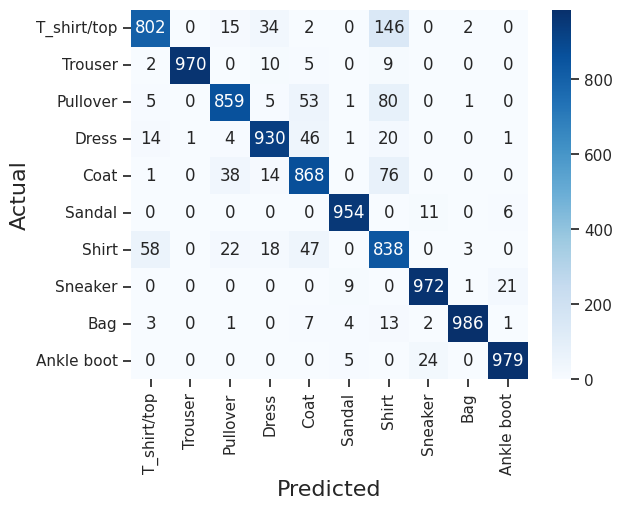

In [ ]:
display(hist_df.iloc[0:3])
classification_rep(OwnBaseline1,criterion,valloader,train_loss1, train_acc1, val_loss1, val_acc1, epoch_his1,'OwnBaseline1')
classification_rep(OwnBaseline2,criterion,valloader,train_loss2, train_acc2, val_loss2, val_acc2, epoch_his2,'OwnBaseline2')
classification_rep(OwnBaseline3,criterion,valloader,train_loss3, train_acc3, val_loss3, val_acc3, epoch_his3,'OwnBaseline3')

#### Obsevations to point out: OwnBaseline (VGGNet inspired)
From the three VGGNet inspired baseline models, OwnBaseline2 performs the best in terms of accuracy, but shows some form of overfitting over time. Most models seem to be overfitting to the train data too well as seen by their very high train accuracy and loss, OwnBaseline1 which is the simplest and lowest parameter count
<br><br>
From the classification report, it is easy to tell that shirt is the most commonly misidentified class is shirt, it has the lowest precision and recall for all 3 OwnBaseline models, and when we check the confusion matrix we can easily tell that shirt is commonly misidentified with T_shirt/top, vice visa. This is not surprising, afterall T_shirt and shirt are both shirts and is rather hard to identify even for me during our EDA earlier. <br><br>
I will select OwnBaseline2 and use it for model improvement since it provided the best highest val acc result

,Lowest Val Loss,Highest Val Acc,Lowest Train Loss,Highest Train Acc,Epoch (Highest Val Acc),Model Description,Parameter
0,0.249656,91.33,0.061010,97.724,22,ResNet4Blocks,"8,028,618"
0,0.253545,91.69,0.007266,99.740,50,ResNet3Blocks,"2,258,890"


ResNet4Blocks


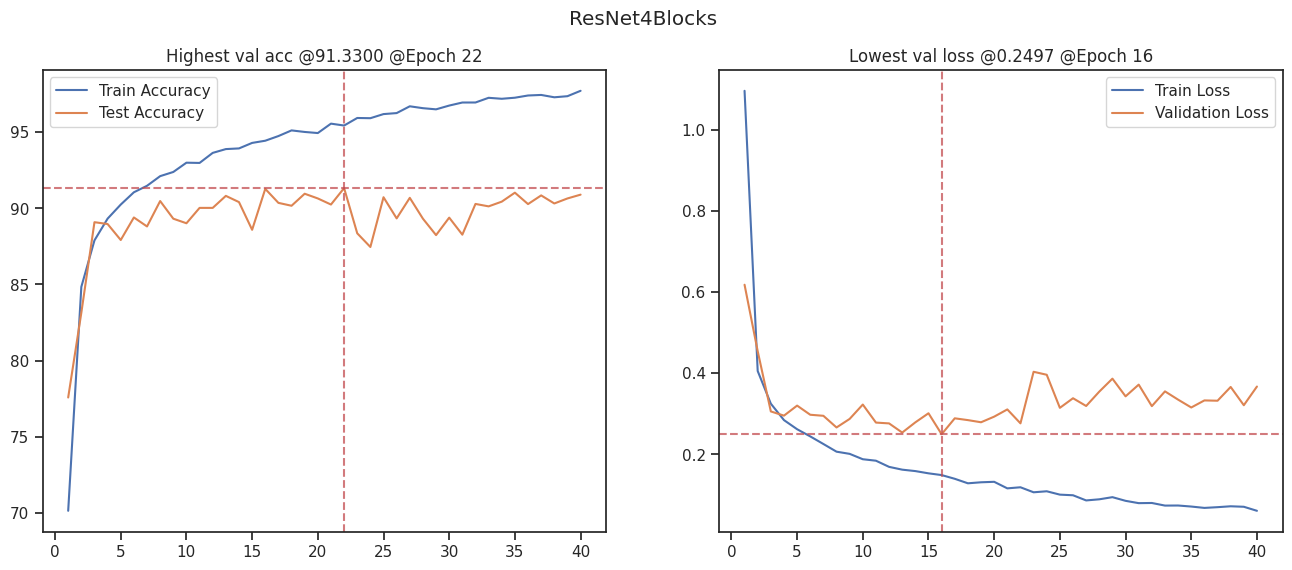

              precision    recall  f1-score   support

 T_shirt/top       0.85      0.85      0.85      1001
     Trouser       1.00      0.98      0.99       996
    Pullover       0.88      0.84      0.86      1004
       Dress       0.88      0.94      0.91      1017
        Coat       0.85      0.82      0.84       997
      Sandal       0.98      0.98      0.98       971
       Shirt       0.74      0.77      0.75       986
     Sneaker       0.96      0.96      0.96      1003
         Bag       0.99      0.98      0.98      1017
  Ankle boot       0.97      0.97      0.97      1008

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



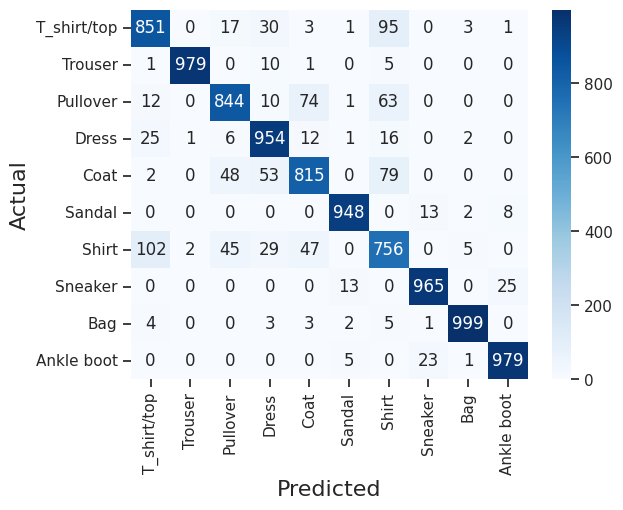

ResNet3Blocks


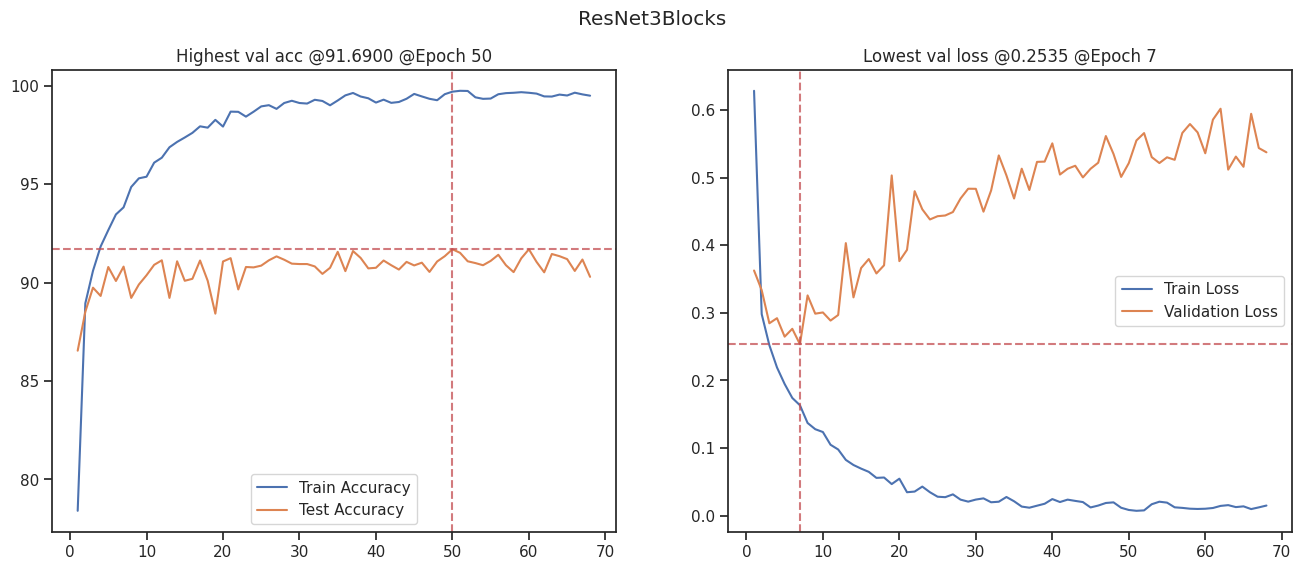

              precision    recall  f1-score   support

 T_shirt/top       0.89      0.80      0.84      1001
     Trouser       0.98      0.99      0.99       996
    Pullover       0.88      0.82      0.85      1004
       Dress       0.94      0.89      0.91      1017
        Coat       0.82      0.85      0.83       997
      Sandal       0.98      0.97      0.97       971
       Shirt       0.67      0.80      0.73       986
     Sneaker       0.95      0.97      0.96      1003
         Bag       0.98      0.97      0.98      1017
  Ankle boot       0.98      0.96      0.97      1008

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



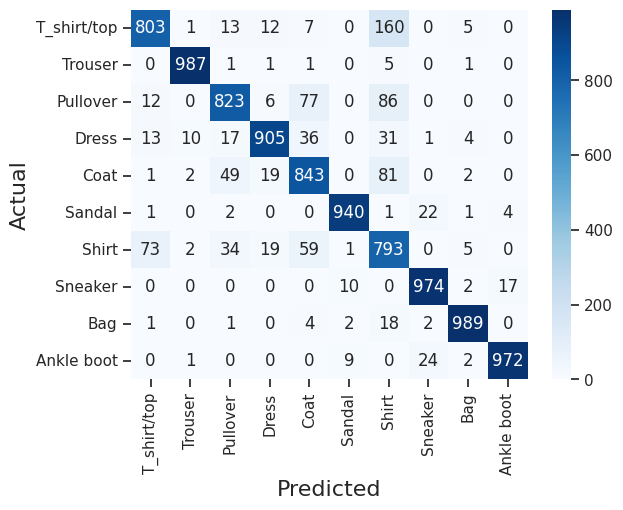

In [ ]:
display(hist_df.iloc[3:5])
classification_rep(ResNet4Blocks,criterion,valloader,train_loss4, train_acc4, val_loss4, val_acc4, epoch_his4,'ResNet4Blocks')
classification_rep(ResNet3Blocks,criterion,valloader,train_loss5, train_acc5, val_loss5, val_acc5, epoch_his5,'ResNet3Blocks')

#### Obsevations to point out: ResNet Custom
ResNet is more robust compared to something like my pervious Baseline model which was inspired by VGGNet and its model complexity has done more harm then good as it has a very good training accuracy (97%-99.5%). However, a very low validation accuracy. With much higher variance we can see that more shirts are misidentified as T_shirts compare to the simpler models above.

,Lowest Val Loss,Highest Val Acc,Lowest Train Loss,Highest Train Acc,Epoch (Highest Val Acc),Model Description,Parameter
0,0.305238,90.11,0.014231,99.514,36,DenseNet4Blocks,"1,253,276"
0,0.295854,89.87,0.039509,98.612,10,DenseNet3Blocks,"1,122,830"


DenseNet4Blocks


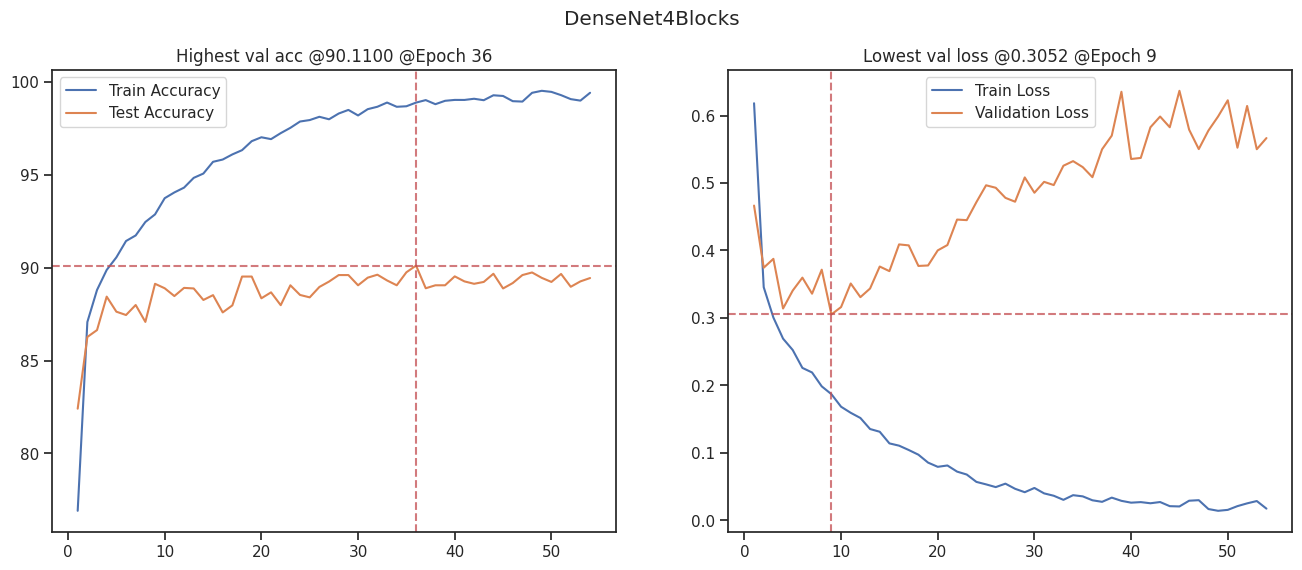

              precision    recall  f1-score   support

 T_shirt/top       0.84      0.84      0.84      1001
     Trouser       0.99      0.98      0.99       996
    Pullover       0.89      0.76      0.82      1004
       Dress       0.88      0.92      0.90      1017
        Coat       0.75      0.89      0.81       997
      Sandal       0.95      0.98      0.96       971
       Shirt       0.74      0.70      0.72       986
     Sneaker       0.96      0.93      0.94      1003
         Bag       0.98      0.98      0.98      1017
  Ankle boot       0.97      0.97      0.97      1008

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



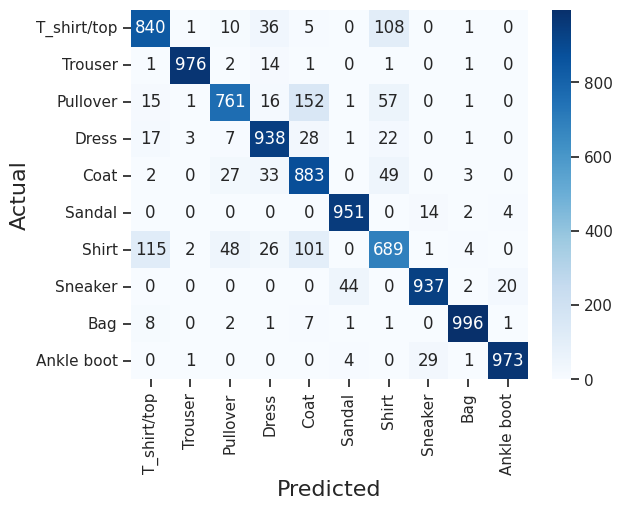

DenseNet3Blocks


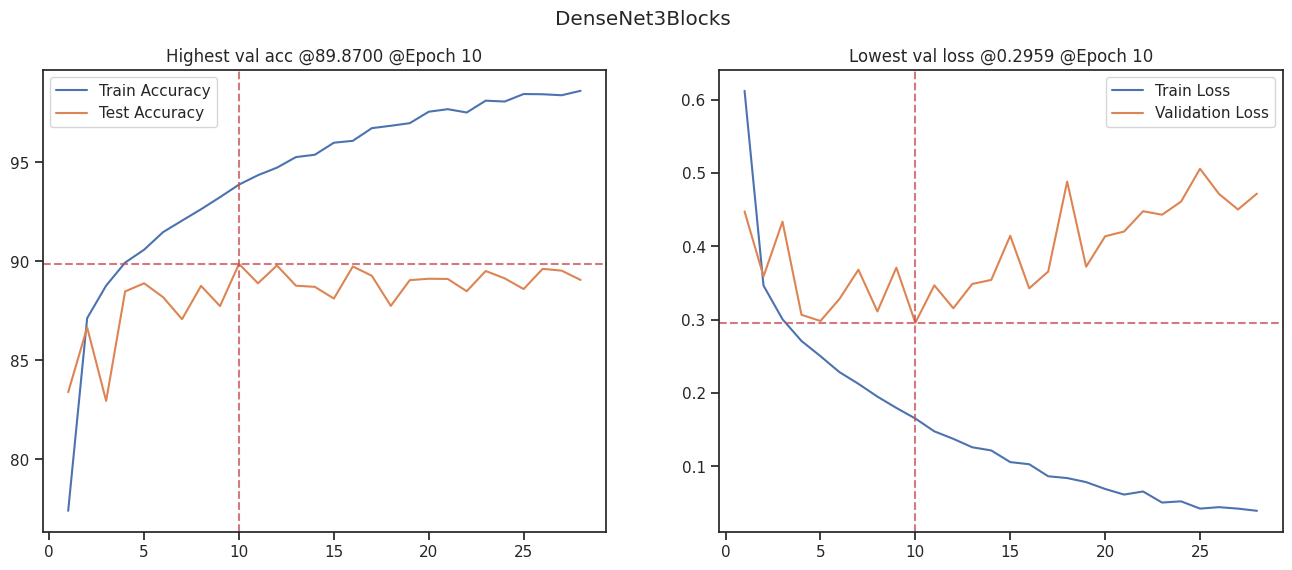

              precision    recall  f1-score   support

 T_shirt/top       0.83      0.85      0.84      1001
     Trouser       0.99      0.99      0.99       996
    Pullover       0.78      0.86      0.82      1004
       Dress       0.91      0.90      0.90      1017
        Coat       0.79      0.82      0.81       997
      Sandal       0.99      0.96      0.98       971
       Shirt       0.77      0.64      0.70       986
     Sneaker       0.96      0.92      0.94      1003
         Bag       0.97      0.97      0.97      1017
  Ankle boot       0.92      0.99      0.95      1008

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



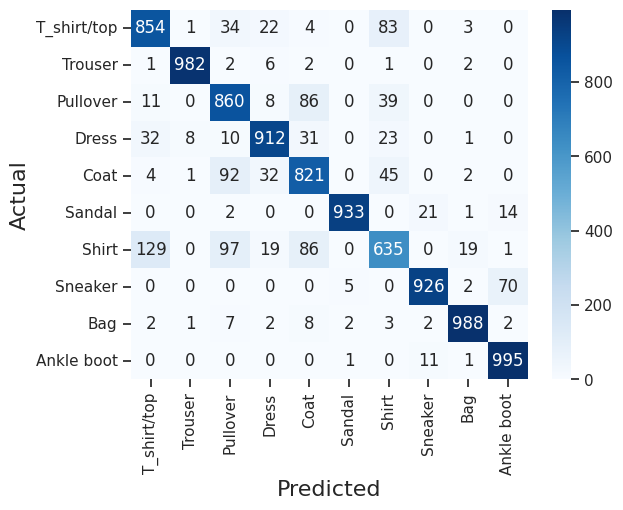

In [ ]:
display(hist_df.iloc[5:])
classification_rep(DenseNet4Blocks,criterion,valloader,train_loss6, train_acc6, val_loss6, val_acc6, epoch_his6,'DenseNet4Blocks')
classification_rep(DenseNet3Blocks,criterion,valloader,train_loss7, train_acc7, val_loss7, val_acc7, epoch_his7,'DenseNet3Blocks')

#### Observations to point out: DenseNet Custom
A similar result is seen here with DenseNet. Extreme overfitting is seen as a huge varaince is seen between the training and validation accuracy and loss. Many shirts and T_shirts are also misidientified.

### Sometimes the best solution is the simplest*.
**The problem with robust architecture and technology:** Even though I have tried to lower ResNet and DenseNet complexity it seems to still overfit even with a high weight decay, while they both uses interesting and impressive architecture and technologies, it did much more harm then good. After all, these architecture are built for classifing much higher resolution image (224x224) with more channels and also used to classify 1000 different classes with 1.2 million images. ResNet and DenseNet were never built with the intend of classifying only 10 classes of single channel and low resolution images with relatively low number of dataset, they were meant to overcome vanishing gradient problems and increase robustness and complexity. However, vanishing gradient and the need to increase model complexity was never a problem in the first place for FashionMNIST classification. Therefore, I have learnt that sometimes the best model out there are actually quite simple and not so fancy especially for a problem like this.

In [ ]:
del train_loss1, train_acc1, val_loss1, val_acc1, epoch_his1, train_loss2, train_acc2, val_loss2, val_acc2, epoch_his2, train_loss3, train_acc3, val_loss3, val_acc3, epoch_his3, train_loss4, train_acc4, val_loss4, val_acc4, epoch_his4, train_loss5, train_acc5, val_loss5, val_acc5, epoch_his5, train_loss6, train_acc6, val_loss6, val_acc6, epoch_his6, train_loss7, train_acc7, val_loss7, val_acc7, epoch_his7, DenseNet4Blocks, DenseNet3Blocks, ResNet4Blocks, ResNet3Blocks, OwnBaseline1,OwnBaseline2,OwnBaseline3 #, train_loss8, train_acc8, val_loss8, val_acc8, epoch_his8

## 4.0) Model Improvement/Hyperparameter tuning
Models we are tuning:
- OwnBaseline2 (VGGNet inspired)

<br>

Augmentation:
- Which augmentation shows the most improvement to our model?

Parameters I am tuning:
- Learning Rate - What is the best learning rate of the model
- Momentum
- Weight Decay - What is the best L2 regularization value
- Convolutional Layers - Find best model complexity
- Optimizer

<br><br>
**SGD with momentum will be used for hyperparameter tuning**: Though much less efficient compared to Adam, SGD slightly generalize better than Adam, therefore I will hyperparameter tune using SGD instate of constantly switching optimizers. Furthermore, the values of the best hyperparameters for Adam and SGD may be very different that I have to search a very wide range of Learning Rate and Weight Decay, which may take a very long time.

### 4.1) Choosing best augmentation set
- One way to improve my model is to find out which types of augmentations is the best. 
- Applying domain knownledge to augmentation: Since we did our EDA we know which augmentation is not desired. For example, augmentation such as VerticalFlip is not desired, while HorizontalFlip and very little RandomRotation is okay.
- OwnBaseline2 will be used as it is not too complex nor simple, and it provided the best result
- In theory, I can do hyperparameter tuning with the different augmentation sets and it may be even better. However, this is rather time consuming and usually there is only a few optimal combination of augmentation to use.
- Replicating to 150K samples with multiple data augmentation could be a good idea too. Especially with a high batch size.
- The different set of augmentation are listed below (From section 2.0):

| Split | Size | Description |
|---|---|---|
| Trainset 1 | 50K  | Normalization (min-max) |
| Trainset 2 (Replicated Data) |  50k + 50k   | Normalization (min-max), RandomHorizontalFlip(0.8), RandomErasing() |
| Trainset 3 (Replicated Data) |  50k + 50k   | Normalization (min-max), RandomHorizontalFlip(0.8), RandomRotation(-5,5) |
| Trainset 4 (Replicated Data) |  50k + 50k   | Normalization (min-max), RandomHorizontalFlip(0.8), RandomErasing(), RandomRotation(5) |
| Trainset 5 (Replicated Data) |  50k + 50k   | Normalization (min-max), RandomErasing(), RandomRotation(-5,5) |
| Trainset 6 (Replicated Data) | 50K + 50k  | Normalization (min-max), RandomHorizontalFlip(0.8), RandomPerspective(0.115,0.4), RandomErasing() |


Reinitialize OwnBaseline1 & OwnBaseline2

In [ ]:
trainloader2 = DataLoader(TensorDataset(trainset2.type('torch.FloatTensor'),traindata_label_100k.type('torch.FloatTensor')), shuffle=True, batch_size=BATCH_SIZE)
trainloader3 = DataLoader(TensorDataset(trainset3.type('torch.FloatTensor'),traindata_label_100k.type('torch.FloatTensor')), shuffle=True, batch_size=BATCH_SIZE)
trainloader4 = DataLoader(TensorDataset(trainset4.type('torch.FloatTensor'),traindata_label_100k.type('torch.FloatTensor')), shuffle=True, batch_size=BATCH_SIZE)
trainloader5 = DataLoader(TensorDataset(trainset5.type('torch.FloatTensor'),traindata_label_100k.type('torch.FloatTensor')), shuffle=True, batch_size=BATCH_SIZE)
trainloader6 = DataLoader(TensorDataset(trainset6.type('torch.FloatTensor'),traindata_label_100k.type('torch.FloatTensor')), shuffle=True, batch_size=BATCH_SIZE)

New dataframe to log our results

In [ ]:
df_augmentation = pd.DataFrame([],columns=['Lowest Val Loss','Highest Val Acc','Lowest Train Loss','Epoch (Highest Val Acc)', 'Model Description', 'Parameter'])

Training the different types of augmentation sets
- Ran twice for reliablility (make sure not a fluke)

In [ ]:
for i in range(2):
    OwnBaseline2_1 = SimpleNet2([2,2,2],1,32,2,512)
    OwnBaseline2_2 = SimpleNet2([2,2,2],1,32,2,512)
    OwnBaseline2_3 = SimpleNet2([2,2,2],1,32,2,512)
    OwnBaseline2_4 = SimpleNet2([2,2,2],1,32,2,512)
    OwnBaseline2_5 = SimpleNet2([2,2,2],1,32,2,512)
    OwnBaseline2_6 = SimpleNet2([2,2,2],1,32,2,512)
    train_loss1, train_acc1, val_loss1, val_acc1, epoch_his1, df_augmentation = _train(OwnBaseline2_1,'OwnBaseline2-No Aug','2,917,482',False,df=df_augmentation,showEpochs=False,trainloader=trainloader1)
    train_loss2, train_acc2, val_loss2, val_acc2, epoch_his2, df_augmentation = _train(OwnBaseline2_2,'OwnBaseline2-HorizontalFlip(0.8),RandomErasing','2,917,482',False,df=df_augmentation,showEpochs=False,trainloader=trainloader2)
    train_loss3, train_acc3, val_loss3, val_acc3, epoch_his3, df_augmentation = _train(OwnBaseline2_3,'OwnBaseline2-RandomHorizontalFlip(0.8),RandomRotation(-5,5)','2,917,482',False,df=df_augmentation,showEpochs=False,trainloader=trainloader3)
    train_loss4, train_acc4, val_loss4, val_acc4, epoch_his4, df_augmentation = _train(OwnBaseline2_4,'OwnBaseline2-RandomHorizontalFlip(0.8),RandomErasing(),RandomRotation(-5,5)','2,917,482',False,df=df_augmentation,showEpochs = False,trainloader=trainloader4)
    train_loss5, train_acc5, val_loss5, val_acc5, epoch_his5, df_augmentation = _train(OwnBaseline2_5,'OwnBaseline2-RandomErasing(), RandomRotation(-5,5)','2,917,482',False,df=df_augmentation,showEpochs = False,trainloader=trainloader5)
    train_loss6, train_acc6, val_loss6, val_acc6, epoch_his6, df_augmentation = _train(OwnBaseline2_6,'OwnBaseline2-RandomHorizontalFlip(0.8),RandomErasing(),RandomPerspective(0.125,0.375)','2,917,482',False,df=df_augmentation,showEpochs = False,trainloader=trainloader6)
clear_output(wait=True)

In [ ]:
df_augmentation

,Lowest Val Loss,Highest Val Acc,Lowest Train Loss,Epoch (Highest Val Acc),Model Description,Parameter,Highest Train Acc
0,0.184186,94.51,0.022331,47,OwnBaseline2-No Aug,"2,917,482",99.204
0,0.167996,94.87,0.031395,36,"OwnBaseline2-HorizontalFlip(0.8),RandomErasing","2,917,482",98.867
0,0.168978,95.16,0.020353,69,"OwnBaseline2-RandomHorizontalFlip(0.8),RandomR...","2,917,482",99.281
0,0.163787,95.13,0.025544,58,"OwnBaseline2-RandomHorizontalFlip(0.8),RandomE...","2,917,482",99.093
0,0.170332,94.65,0.033518,20,"OwnBaseline2-RandomErasing(), RandomRotation(-...","2,917,482",98.800
0,0.172038,94.80,0.030348,42,"OwnBaseline2-RandomHorizontalFlip(0.8),RandomE...","2,917,482",98.925
0,0.180670,94.71,0.017113,76,OwnBaseline2-No Aug,"2,917,482",99.388
0,0.169142,95.04,0.026290,48,"OwnBaseline2-HorizontalFlip(0.8),RandomErasing","2,917,482",99.073
0,0.162305,95.17,0.023202,51,"OwnBaseline2-RandomHorizontalFlip(0.8),RandomR...","2,917,482",99.157
0,0.166328,95.21,0.024472,59,"OwnBaseline2-RandomHorizontalFlip(0.8),RandomE...","2,917,482",99.126


Seems like we are pretty confident that augmentation improves the model validation loss and accuracy. However, to choose the data augmentation set, I will evaluate no augmentation set with the top 2 augmentation sets.
<br><br>
Evaluating 3 sets: <br>

| Split | Size | Description | Average Val Acc |
|---|---|---|---|
| Trainset 1 | 50K  | Normalization (min-max) | 94.61%|
| Trainset 3 (Replicated Data) |  50k + 50k   | Normalization (min-max), RandomHorizontalFlip(0.8), RandomRotation(-5,5) | 95.165% |
| Trainset 4 (Replicated Data) |  50k + 50k   | Normalization (min-max), RandomHorizontalFlip(0.8), RandomErasing(), RandomRotation(5) | 95.17% |

Lowest Val Loss                        0.18067
Highest Val Acc                          94.71
Lowest Train Loss                     0.017113
Epoch (Highest Val Acc)                     76
Model Description          OwnBaseline2-No Aug
Parameter                            2,917,482
Highest Train Acc                       99.388
Name: 0, dtype: object

No Augmentation


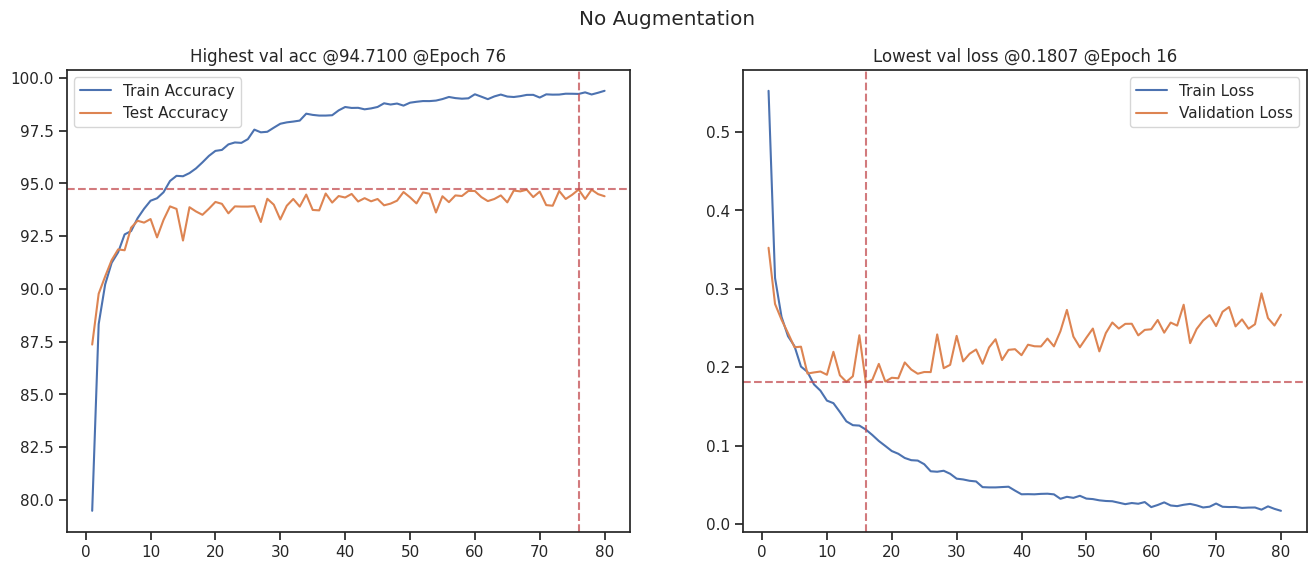

              precision    recall  f1-score   support

 T_shirt/top       0.92      0.89      0.90      1001
     Trouser       1.00      0.99      0.99       996
    Pullover       0.93      0.92      0.92      1004
       Dress       0.94      0.94      0.94      1017
        Coat       0.89      0.92      0.91       997
      Sandal       1.00      0.99      0.99       971
       Shirt       0.83      0.84      0.84       986
     Sneaker       0.97      0.98      0.98      1003
         Bag       0.99      0.99      0.99      1017
  Ankle boot       0.98      0.98      0.98      1008

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



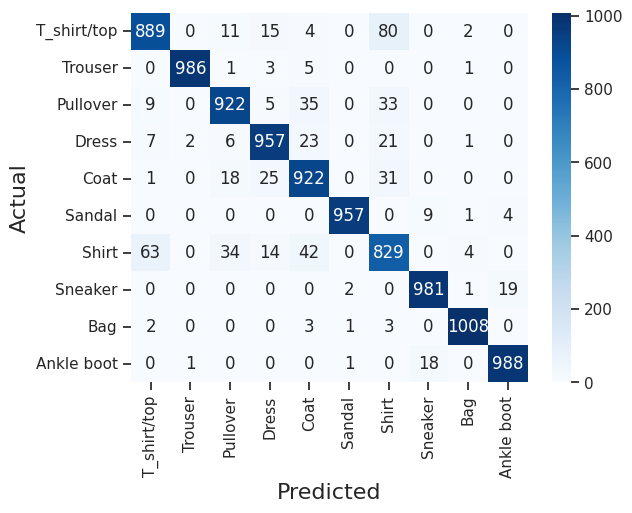

Lowest Val Loss                                                     0.166328
Highest Val Acc                                                        95.21
Lowest Train Loss                                                   0.024472
Epoch (Highest Val Acc)                                                   59
Model Description          OwnBaseline2-RandomHorizontalFlip(0.8),RandomE...
Parameter                                                          2,917,482
Highest Train Acc                                                     99.126
Name: 0, dtype: object

RandomHorizontalFlip(0.8),RandomRotation(-5,5)


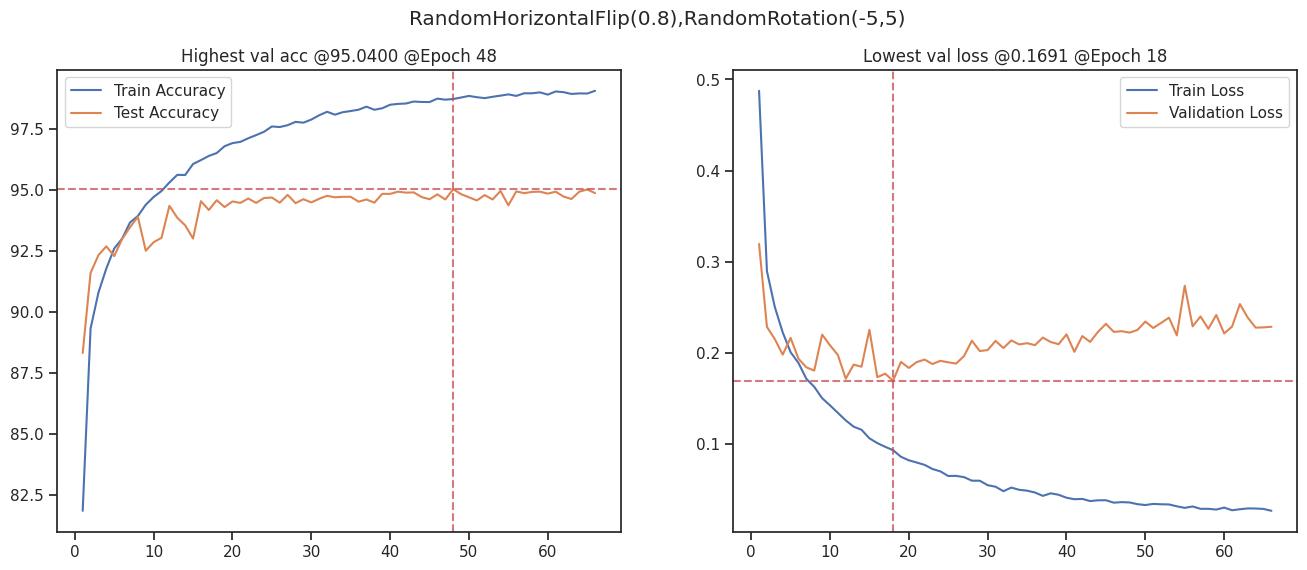

              precision    recall  f1-score   support

 T_shirt/top       0.90      0.91      0.91      1001
     Trouser       0.99      0.99      0.99       996
    Pullover       0.90      0.94      0.92      1004
       Dress       0.94      0.95      0.95      1017
        Coat       0.93      0.90      0.92       997
      Sandal       0.99      0.99      0.99       971
       Shirt       0.87      0.84      0.86       986
     Sneaker       0.97      0.99      0.98      1003
         Bag       0.99      0.99      0.99      1017
  Ankle boot       0.99      0.97      0.98      1008

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



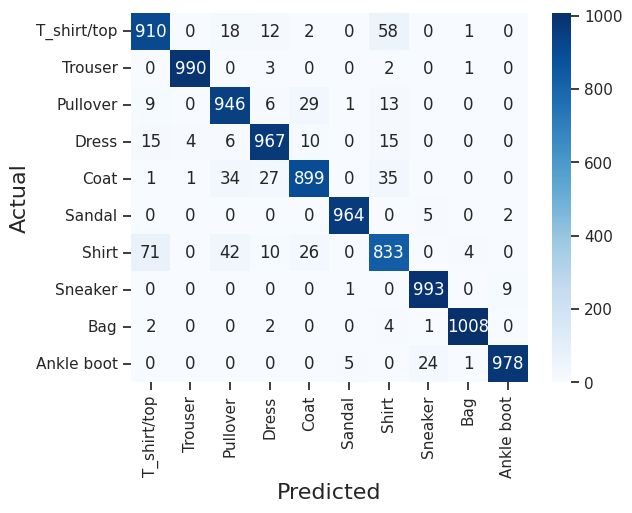

Lowest Val Loss                                                     0.162305
Highest Val Acc                                                        95.17
Lowest Train Loss                                                   0.023202
Epoch (Highest Val Acc)                                                   51
Model Description          OwnBaseline2-RandomHorizontalFlip(0.8),RandomR...
Parameter                                                          2,917,482
Highest Train Acc                                                     99.157
Name: 0, dtype: object

RandomHorizontalFlip(0.8),RandomPerspective(),RandomErasing


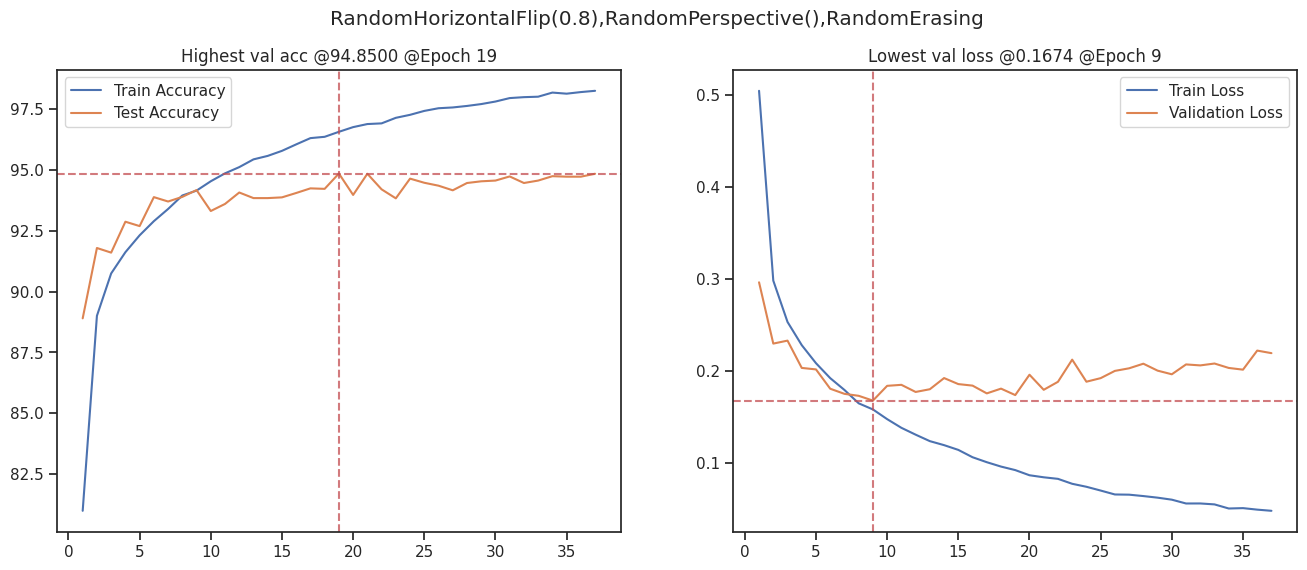

              precision    recall  f1-score   support

 T_shirt/top       0.95      0.86      0.90      1001
     Trouser       1.00      0.99      0.99       996
    Pullover       0.92      0.94      0.93      1004
       Dress       0.95      0.95      0.95      1017
        Coat       0.92      0.91      0.92       997
      Sandal       1.00      0.99      0.99       971
       Shirt       0.81      0.89      0.85       986
     Sneaker       0.98      0.98      0.98      1003
         Bag       0.99      0.99      0.99      1017
  Ankle boot       0.98      0.98      0.98      1008

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



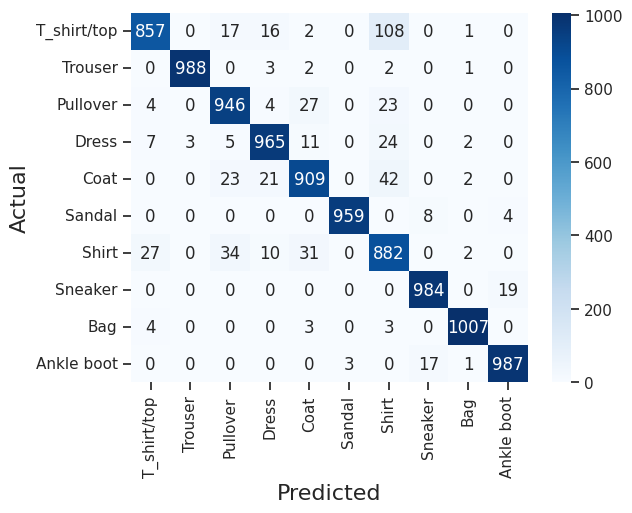

In [ ]:
display(df_augmentation.iloc[-6])
classification_rep(OwnBaseline2_1,criterion,valloader,train_loss1, train_acc1, val_loss1, val_acc1, epoch_his1,'No Augmentation')

display(df_augmentation.iloc[-3])
classification_rep(OwnBaseline2_2,criterion,valloader,train_loss2, train_acc2, val_loss2, val_acc2, epoch_his2,'RandomHorizontalFlip(0.8),RandomRotation(-5,5)')

display(df_augmentation.iloc[-4])
classification_rep(OwnBaseline2_6,criterion,valloader,train_loss6, train_acc6, val_loss6, val_acc6, epoch_his6,'RandomHorizontalFlip(0.8),RandomPerspective(),RandomErasing')


Since augementation set 3&4 are good and differ less than 0.1%, and their learning curve looks roughly similar. I will pick the augmentation set with the least wrongly predicted Shirt/T_shirt class, as from our pervious EDA we noted that Shirt/T_shirt are the ones that are generally misidentified.
<br>
- No augmentation predicted 1718/2000 Shirts/T_shirt correctly
- RandomHorizontalFlip(0.8), RandomRotation(-5,5) predicted 1739/2000 Shirts/T_shirt correctly
- RandomHorizontalFlip(0.8), RandomErasing(), RandomRotation(5) predicted 1743/2000 Shirts/T_shirt correctly
<br>

trainloader4 (100K samples - HorizontalFlip(0.8),RandomRotation(-5,5),RandomErasing()) will be used during hyperparameter tuning.

In [ ]:
del trainloader2, trainloader3, trainloader5, trainloader6, trainset1, trainset2, trainset3, trainset5, trainset6, traindata_label, OwnBaseline2_1,OwnBaseline2_2,OwnBaseline2_3,OwnBaseline2_4,OwnBaseline2_5,OwnBaseline2_6

### 4.2) Hyperparameter tuning
<br>
There are tons of hyperparameter to tune. However, I have selected 5 I feel matters the most along with a little bit of research as well.

[Andrew Ng, 2017 - Unofficial](https://www.youtube.com/watch?v=dSDZ-7I5FoA&t=153s)



<br>

Hyperparameters I am tuning:
- Learning Rate - What is the best learning rate of the model
- Momentum - What is the best momentum to use, finding the optimal momentum could allow me to use a lower LR and archieve a better lower loss minima.
- Weight Decay - What is the best L2 regularization value
- Convolutional Layers - Find best model complexity
- Optimizer - I am going to test SGD vs SAM optimizer [[Foret et al.,2021](https://arxiv.org/pdf/2010.01|412.pdf)]


With 5 hyperparameters to already tune it would be very time consuming and computational demanding that it will become impractical to tune all possible hyperparameters that I could think of. However, if computational power and time is not an issue I would definitely hyperparameter tune these as well:
- Fully connected nerons - Find most optimal fully connected (classification) neurons
- Augmentation probability parameter - Find best probability parameter for data augmentation (time consuming with little improvement)
- Batch size - Find best batch size for the model (Need to scale batch size along with learning rate, lower number of batch size (and low LR) can lead to longer waiting time. However, lower number of batch size has shown to improve generalization and regularization)
- Learning rate scheduler: Since I already have learning rate with momemtum, hyperparameter tuning the scheduler might not be as effective since momemtum already help speed up and slow down my learning rate. I will still use a generic scheduler though.
- Filter growth rate - Find the best expansion rate of filter for the model (to increase/lower model complexity) usually growth rate is set to 2. Not usually tuned.
- Initial filter count - Find the best initial filter (to increase/lower model complexity) (default - set to 32)

<br><br>

**Hyperparameter Technique:**
For hyperparameter tuning I will built a custom random hyperparameter tuner, the technique used to find the most optimal hyperparameters for my baseline model would be coarse to fine (double random hypertuning) suggested by Andrew Ng. Where for my first random hyperparameter search I will search a fairly wide range of value and then I will do a 2nd random hyperparameter search where I can cut down on the range of hyperparameter values and search a subset of where my most optimal hyperparameters will most likely be at based on where my top few highest validation acc/loss are. For the image example below, there is 2 hand drawn boxes done by Andrew Ng, the outter hand drawn box would be the first random search, and the inner box would be the 2nd random search.
<img src="https://x-wei.github.io/images/Ng_DLMooc_c2wk3/pasted_image002.png" width="750" alt='Coarse To Fine'><br>


[[Image source: Andrew Ng, 2017](https://www.youtube.com/watch?v=dSDZ-7I5FoA&t=340s)]


Importing the SAM optimizer for pytorch [[Foret et al.,2021](https://arxiv.org/pdf/2010.01|412.pdf)]

In [ ]:
!git clone https://github.com/davda54/sam.git

Cloning into 'sam'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 200 (delta 73), reused 66 (delta 60), pack-reused 104
Receiving objects: 100% (200/200), 659.65 KiB | 21.28 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
from sam.sam import SAM

Preping trainloader - removing irrelavent trainsets from memory
- Batch size reduced from 1024 -> 512 (Any lower will take too long)
- **Even though lower batch size offers more regularization and better generalization, I will still have to choose a relatively high batch size to train my models faster...I believe the trade off between finding better hyperparameter and batch size is worth it here.** Stronger data augmentation would be good to use as well

In [ ]:
BATCH_SIZE=512

In [ ]:
trainloader4 = DataLoader(TensorDataset(trainset4.type('torch.FloatTensor'),traindata_label_100k.type('torch.FloatTensor')), shuffle=True, batch_size=BATCH_SIZE)
valloader = DataLoader(TensorDataset(valset.type('torch.FloatTensor'),valdata_label.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)
del trainset1, trainset2, trainset3, trainset5, trainset6


#### 4.2.1) Random Grid Search 1:
- LR: **logscaled range from 0.04-0.004**, logscaled because the affect of lower LR change is much more obvious compared to higher values
- Momemtum: **linspace range from 0.9 - 0.96**, linspace because the affect of momentum change is almost linear 
- Weight Decay: **logscaled range from 0.1-0.00001**, logscaled because the affect of lower weight decay change is much more obvious compared to higher values
- Optimizer: **Either SGD or SAM** will be used
- Layer: **Only the last block will +-1 layer** (slightly increase or decrease complexity only), any more layers to test will create a lot more total trials, making the hyperparameter tuning ineffective and inefficient

#### Generic scheduler will be used (LAMBDA LR) for model improvement (AKA Learning Rate Decay) <br><br>
lrepoch=lrinitial∗Lambda(epoch)  <br>

See graph for more infomartion - 100 epochs example (epoch and learning rate decay overtime)

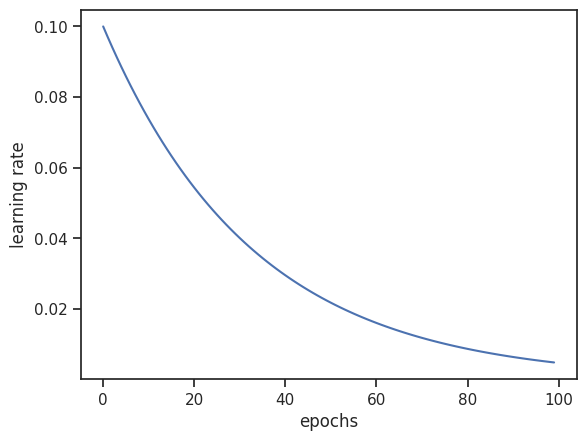

In [ ]:
epoch=100
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
lambda1 = lambda epoch: 0.97 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


lrs = []
for i in range(epoch):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
plt.xlabel('epochs')
plt.ylabel('learning rate')
plt.plot(range(epoch),lrs)
plt.show()

Since we will be running 100 epochs I will set a slightly lower earlystopper
- If val loss or accuracy do not improve in 15 epoch - stop training

In [ ]:
# init early stopper with patience of 15
earlyStopper = EarlyStopping(15)

#### 4.2.1.1) Some functions preparation:
- Editing train function to integrate SAM optimizer and making it more efficient (reducing redundant code that display train loss and accuracy, ~0.6s improvement per epoch)
- Hyperparameter cacher

SAM optimizer uses a double forward-backward pass, so I have to edit the train function for SAM optimizer, for resources and documentation see [Original Reseacher's Github](https://github.com/davda54/sam.git)

In [ ]:
def train_sam(model, loader, optimizer, NUM_EPOCHS, criterion, valloader=None,earlystopper=None,showEpoch=True,scheduler=scheduler):
    val_loss_his = []
    val_accuracy_his = []
    epoch_his = []
    earlystopper.reset()
    for epoch in range(NUM_EPOCHS):
        t0 = time.time()
        for data in loader:
            img, label = data 
            img = img.to(device)
            label = label.to(device)
            outputs = model(img)
            loss = criterion(outputs, label)  # use this loss for any training statistics
            loss.backward()
            optimizer.first_step(zero_grad=True)
            outputs = model(img)
          # second forward-backward pass
            criterion(outputs, label).backward()  # make sure to do a full forward pass
            optimizer.second_step(zero_grad=True)
        scheduler.step()
        val_loss, val_accuracy = validate(model, criterion, valloader)
        val_loss_his.append(val_loss)
        val_accuracy_his.append(val_accuracy)
        epoch_his.append(epoch+1)
        if showEpoch:
            print(f'- [Epoch {epoch+1}/{NUM_EPOCHS}] |_|_| Val Loss: {val_loss:.3f} | Val Accuracy: {val_accuracy} | Est: {time.time() - t0:.2f}s')
        if earlyStopper(val_accuracy,val_loss):
            print(f'EarlyStopper triggered at epochs: {epoch+1} \n*No improvement to validation loss and accuracy could be seen for the pass {earlyStopper.patience} epochs')
            break
    print(f'Highest Val Accuracy: {max(val_accuracy_his)}  @ epoch {epoch_his[val_accuracy_his.index(max(val_accuracy_his))]} | Lowest Val Loss: {min(val_loss_his)}  @ epoch {epoch_his[val_loss_his.index(min(val_loss_his))]}')
    return _,_, val_loss_his, val_accuracy_his,epoch_his

This function cache my hyperparameter tuning state to a text file. Since I usually hypertune on different systems I think its nice to write a feature like this...Therefore, I can easily stop my hyperparameter tuning halfway and continue at a later time. It also serves as a backup for the trialed hyperparameters if my system ever crashes.

In [ ]:
def loadTunerState(stateData = 'hyperparmState.csv'):
    with open(os.path.join(sys.path[0], stateData),'r') as file:
        highest_val_acc = []
        val_acc_hist = []
        trial_hist = []
        total_time = 0
        rawTxt = file.read()
        splited = rawTxt.split('\n')
        for val in splited[0].split(','):
            highest_val_acc.extend([float(val)])
        for val in splited[1].split(','):
            val_acc_hist.extend([float(val)])
        c = 0
        trial = []
        for val in splited[2].split(','):
            c += 1
            trial.extend([float(val)])
            if c%4==0:
                trial_hist.append(trial)
                trial = []
        total_time = float(splited[3])
        saved_time = float(splited[4])
    file.close()
    return highest_val_acc, val_acc_hist, trial_hist, total_time, saved_time

In [ ]:
def saveTunerState(highest_val_acc,val_acc_hist,trial_hist,stoppedTime,stateData = 'hyperparmState.csv'):
    inp = ''
    with open(os.path.join(sys.path[0], stateData),'w') as file:
        for val in highest_val_acc:
            inp += f'{val},'
        file.write(inp[:-1]+'\n')
        inp = ''
        for val in val_acc_hist:
            inp += f'{val},'
        file.write(inp[:-1]+'\n')
        inp = ''
        for val in trial_hist:
            for val2 in val:
                inp += f'{val2},'
        file.write(inp[:-1]+'\n'+str(stoppedTime)+'\n'+str(time.time()))
    file.close()
    return

Function for my first random search
- I didnt implement a hyperparameter cacher at this point yet (for my first random search)...its only after doing my first random search then I realised how annoying it is to restart my trials from trial #1 whenever I need to stop my computer

In [ ]:
def NetRandomTuner(LR_range = np.logspace(1,2,num=10)/1000 * 0.4,WD_range=np.logspace(1,5,num=10)/1000000,Beta_range=np.linspace(0.9,0.96, num=6),layer_range=np.arange(2,4), optimizer_choice=np.array(['SGD','SAM']),trials=50,epoch=80):
    possible_trials=[]
    highest_val_acc = [0,0,0]
    val_acc_hist = []
    trial_hist = []
    for LR, WD, B3, M, O in itertools.product(*(LR_range,WD_range,Beta_range,layer_range, optimizer_choice)):
        possible_trials.append([LR, WD, B3, M, O])
    # shuffle all possible trials
    random.shuffle(possible_trials)
    trial_count = 0
    t0 = time.time()
    for trial in possible_trials:
        print(trial)
        t1 = time.time()
        if trial_count == trials:
            print(f'\n\nTrial ended at trial #{trial_count}')
            break
        trial_count += 1
        # A lot more options to tune if you want. Refer to section 4.2 discussion (growthrate,filters,neurons)
        model = SimpleNet2([2,2,trial[3]],1,32,2,512)
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
            model = model.to(device)
        else:
            model = model.to(device)
        if trial[4] == 'SGD':
            opt = optim.SGD(model.parameters(),lr=trial[0], weight_decay=trial[1], momentum=trial[2])
            scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)
            train_loss, train_acc, val_loss, val_acc, epoch_his = train(model, trainloader4,opt,epoch,criterion,valloader,earlyStopper,True,scheduler)
        else:
            opt_base = optim.SGD
            opt = SAM(model.parameters(), opt_base, lr=trial[0], momentum=trial[2], weight_decay=trial[1])
            scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)
            train_loss, train_acc, val_loss, val_acc, epoch_his = train_sam(model, trainloader4,opt,epoch,criterion,valloader,earlyStopper,True,scheduler)
        if max(val_acc) > highest_val_acc[0]:
            highest_val_acc = [max(val_acc),trial_count-1,epoch_his[val_acc.index(max(val_acc))]]
        trial_hist.append([trial[0],trial[1],trial[2],trial[3],trial[4],epoch_his[val_acc.index(max(val_acc))]])
        val_acc_hist.extend([max(val_acc)])
        clear_output()
        print(f'''
Trial #{trial_count} Finished - Search Time {(time.time()-t1)/60:.2f} Mins
Total Time Elapsed: {(time.time()-t0)/60:.2f} Mins\n
Hyperparameters\t\t|Trial Values:
Learning Rate\t\t|{trial[0]:.6f}\t\t|{trial_hist[highest_val_acc[1]][0]:.6f}
Weight Decay (L2)\t|{trial[1]:.6f}\t\t|{trial_hist[highest_val_acc[1]][1]:.6f}
Momentum\t\t|{trial[2]:.6f}\t\t|{trial_hist[highest_val_acc[1]][2]:.6f}
Last Layer No\t\t|{trial[3]}\t\t\t|{trial_hist[highest_val_acc[1]][3]}
Optimizer\t\t|{trial[4]}\t\t\t|{trial_hist[highest_val_acc[1]][4]}\n
Highest Val Acc\t\t|{max(val_acc)}\t\t\t|{highest_val_acc[0]:.2f}
Epoch (Highest Val)\t|{epoch_his[val_acc.index(max(val_acc))]}\t\t\t|{highest_val_acc[2]}\n\n''')
    return trial_hist, val_acc_hist

#### Running my first random search

In [ ]:
trial_hist1, val_acc_hist1 = NetRandomTuner(epoch=100,trials=75)

Trial #75 Finished - Search Time 10.59 Mins
Total Time Elapsed: 917.76 Mins

Hyperparameters		|Trial Values: #75	|Best Trial Values: #67

Learning Rate		|0.011130		|0.005166
Weight Decay (L2)	|0.035938		|0.004642
Momentum		|0.936000		|0.948000
Last Layer No		|3			|2
Optimizer		|SGD			|SAM

Highest Val Acc		|94.33			|95.38
Epoch (Highest Val)	|67			|64


[0.02397937001275764, 0.03593813663804626, 0.924, 2, 'SGD']


Trial ended at trial #75


now lets analysis our top 5 highest and top 5 lowest validation accuracy hyperparameters
- After this analysis we can drastically cut down on the range of hyperparameters to hyperparameter tune for our 2nd random gridsearch.

Function to display top N & bottom N highest validation accuracy of the hyperparameters and validation history recorded during random search.

In [ ]:
def hyperparmsOverview(val_acc_hist, trial_hist, returnNum = 3):
    df_top = pd.DataFrame([],columns=['Highest val acc','LR','Weight decay','Momentum','Last block layers','Optimizer','Epoch (of Highest Val Acc)'])
    df_btm = pd.DataFrame([],columns=['Highest val acc','LR','Weight decay','Momentum','Last block layers','Optimizer','Epoch (of Highest Val Acc)'])
    top = sorted(zip(val_acc_hist, trial_hist), reverse=True)[:returnNum]
    btm = sorted(zip(val_acc_hist, trial_hist), reverse=False)[:returnNum]
    for i,e in zip(top,btm):
        df_top = pd.concat([df_top,pd.DataFrame([[i[0],i[1][0],i[1][1],i[1][2],i[1][3],i[1][4],i[1][5]]],columns=['Highest val acc','LR','Weight decay','Momentum','Last block layers','Optimizer','Epoch (of Highest Val Acc)'])])
        df_btm = pd.concat([df_btm,pd.DataFrame([[e[0],e[1][0],e[1][1],e[1][2],e[1][3],e[1][4],e[1][5]]],columns=['Highest val acc','LR','Weight decay','Momentum','Last block layers','Optimizer','Epoch (of Highest Val Acc)'])])
        
    print(f'Top {returnNum} Highest Val Accuracy Hyperparameters')
    display(df_top)
    print(f'\n\nBottom {returnNum} Highest Val Accuracy Hyperparameters')
    display(df_btm)

In [ ]:
hyperparmsOverview(val_acc_hist1, trial_hist1)

Top 3 Highest Val Accuracy Hyperparameters


,Highest val acc,LR,Weight decay,Momentum,Last block layers,Optimizer,Epoch (of Highest Val Acc)
0,95.38,0.005166,0.004642,0.948,2,SAM,64
0,95.34,0.040000,0.000215,0.924,2,SAM,70
0,95.31,0.023979,0.004642,0.960,2,SAM,82




Bottom 3 Highest Val Accuracy Hyperparameters


,Highest val acc,LR,Weight decay,Momentum,Last block layers,Optimizer,Epoch (of Highest Val Acc)
0,10.17,0.040000,0.1,0.960,2,SAM,4
0,48.32,0.040000,0.1,0.936,3,SAM,2
0,57.02,0.030971,0.1,0.936,2,SAM,5


A collection of analysis is shown bellow:
- Last blocker layer 2 generally does well
- SAM optimizer does well too
- Higher learning rate with high momentum does the worst
- Weight decay of 0.1 is too high, while weight decay around 0.004 is decent
- Lower learning rate paired with a corresponding lower momentum yield better results
- Generally the better hyperparameters are able to train for much more epochs and achieve better generalization

<br>

With these knownledge we can effective cut our 2nd random search field to:
- LR: **logscaled range from 0.04-0.004**, logscaled because the affect of lower LR change is much more obvious compared to higher values
- Momemtum: **linspace range from 0.924 - 0.96**, linspace because the affect of momentum change is almost linear 
- Weight Decay: **logscaled range from 0.008-0.00008**, logscaled because the affect of lower weight decay change is much more obvious compared to higher values
<br><br>

 **We can completely elimate optimizer and layer tuning from hyperparameter tuning**, since it is obvious SAM optimizer is better than SGD and 2 layers for our last block is better than 3 layers.* 
 <br><br>
 
Nice...our number of total combinations of hyperparameters have been reduced drastically. We are searching a much better range of hyperparameters.

### 4.2.2) Random Grid Search 2:
- Hyperparameter cacher implemented

In [ ]:
def NetRandomTuner2(hyperparameterCacheFile = None,saveAs = 'hyperparmState.csv',cacheEvery=3,LR_range = np.logspace(1,2,num=10)/1000 * 0.4,WD_range=np.logspace(1,3,num=10)/10000 * 0.08,Beta_range=np.linspace(0.924,0.96, num=5),trials=50,epoch=80):
    possible_trials=[]
    for LR, WD, B3 in itertools.product(*(LR_range,WD_range,Beta_range)):
        possible_trials.append([LR, WD, B3])
    # shuffle all possible trials
    random.shuffle(possible_trials)
    if hyperparameterCacheFile == None:
        highest_val_acc = [0,0,0]
        val_acc_hist = []
        trial_hist = []
        loaded_trial_hist = []
        trial_count = 0
        t0 = time.time()
    else:
        highest_val_acc, val_acc_hist, trial_hist, t0, time_saved = loadTunerState(hyperparameterCacheFile)
        # New t0 = time of loading - time of saving
        t0 += time.time() - time_saved
        trial_count = len(val_acc_hist)
        highest_val_acc[1] = int(highest_val_acc[1]) # just making sure is correct datatype
        highest_val_acc[2] = int(highest_val_acc[2])
        loaded_trial_hist = []
        for row in trial_hist:
            loaded_trial_hist.append(row[:3])
    opt_base = optim.SGD
    for trial in possible_trials:
        # If trial is already ran from pervious history, skip trial and go to next
        if trial in loaded_trial_hist:
            pass
        else:
            print('Next trial: ',trial)
            t1 = time.time()
            if trial_count == trials:
                print(f'\n\nTrial ended at trial #{trial_count}')
                break
            trial_count += 1
            # A lot more options to tune if you want. Refer to section 4.2 discussion (growthrate,filters,neurons)
            model = SimpleNet2([2,2,2],1,32,2,512)
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)
                model = model.to(device)
            else:
                model = model.to(device)
            opt = SAM(model.parameters(), opt_base, lr=trial[0], momentum=trial[2], weight_decay=trial[1])
            scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)
            _, _, _, val_acc, epoch_his = train_sam(model, trainloader4,opt,epoch,criterion,valloader,earlyStopper,True,scheduler)
            if max(val_acc) > highest_val_acc[0]:
                highest_val_acc = [max(val_acc),trial_count-1,epoch_his[val_acc.index(max(val_acc))]]
            trial_hist.append([trial[0],trial[1],trial[2],epoch_his[val_acc.index(max(val_acc))]])
            val_acc_hist.extend([max(val_acc)])
            clear_output()
            print(f'''
Trial #{trial_count} Finished - Search Time {(time.time()-t1)/60:.2f} Mins
Total Time Elapsed: {(time.time()-t0)/60:.2f} Mins\n
Hyperparameters\t\t|Trial Values: #{trial_count}\t|Best Trial Values: #{highest_val_acc[1]+1}\n
Learning Rate\t\t|{trial[0]:.6f}\t\t|{trial_hist[highest_val_acc[1]][0]:.6f}
Weight Decay (L2)\t|{trial[1]:.6f}\t\t|{trial_hist[highest_val_acc[1]][1]:.6f}
Momentum\t\t|{trial[2]:.6f}\t\t|{trial_hist[highest_val_acc[1]][2]:.6f}
Highest Val Acc\t\t|{max(val_acc)}\t\t\t|{highest_val_acc[0]:.2f}
Epoch (Highest Val)\t|{epoch_his[val_acc.index(max(val_acc))]}\t\t\t|{highest_val_acc[2]}\n\n
''')
            if trial_count % cacheEvery == 0:
                saveTunerState(highest_val_acc,val_acc_hist,trial_hist,t0,stateData = saveAs)
    return trial_hist, val_acc_hist

In [ ]:
trial_hist1, val_acc_hist1 = NetRandomTuner2('hyperparmState2.csv',trials=70,epoch=100, saveAs='hyperparmState.csv')


Trial #70 Finished - Search Time 2.30 Mins
Total Time Elapsed: 935.70 Mins

Hyperparameters		|Trial Values: #70	|Best Trial Values: #9

Learning Rate		|0.040000		|0.014987
Weight Decay (L2)	|0.008000		|0.000619
Momentum		|0.951000		|0.960000
Highest Val Acc		|91.64			|95.42
Epoch (Highest Val)	|15			|65



Next trial:  [0.011130237608828497, 0.0017235477520255059, 0.951]


Trial ended at trial #70


About 150 trials are done in total @100 max epochs with 15 epochs early stopping, training took a total time of 20+ hours, a faster time could be taken if I sticked to just 1 fast machine (10+ hours perhaps) instead of multiple different machines, my best trial is trial #79/150 too so if I stop my hyperparameter tuning much earlier it would much faster (but of course I won't know when my hyperparameter tuner will reach its highest val accuracy). Nonetheless, the analysis of the secoond random search will be shown below.

In [ ]:
def hyperparmsOverview(val_acc_hist, trial_hist, returnNum):
    df_top = pd.DataFrame([],columns=['Highest val acc','LR','Weight decay','Momentum','Epoch (of Highest Val Acc)'])
    df_btm = pd.DataFrame([],columns=['Highest val acc','LR','Weight decay','Momentum','Epoch (of Highest Val Acc)'])
    top = sorted(zip(val_acc_hist, trial_hist), reverse=True)[:returnNum]
    btm = sorted(zip(val_acc_hist, trial_hist), reverse=False)[:returnNum]
    for i,e in zip(top,btm):
        df_top = pd.concat([df_top,pd.DataFrame([[i[0],i[1][0],i[1][1],i[1][2],i[1][3]]],columns=['Highest val acc','LR','Weight decay','Momentum','Epoch (of Highest Val Acc)'])])
        df_btm = pd.concat([df_btm,pd.DataFrame([[e[0],e[1][0],e[1][1],e[1][2],e[1][3]]],columns=['Highest val acc','LR','Weight decay','Momentum','Epoch (of Highest Val Acc)'])])
        
    print(f'Top {returnNum} Highest Val Accuracy Hyperparameters')
    display(df_top)
    print(f'\n\nBottom {returnNum} Highest Val Accuracy Hyperparameters')
    display(df_btm)

In [ ]:
hyperparmsOverview(val_acc_hist1, trial_hist1,returnNum=5)

Top 5 Highest Val Accuracy Hyperparameters


,Highest val acc,LR,Weight decay,Momentum,Epoch (of Highest Val Acc)
0,95.42,0.014987,0.000619,0.960,65.0
0,95.37,0.010781,0.004796,0.951,44.0
0,95.36,0.023979,0.004796,0.924,70.0
0,95.32,0.023979,0.002875,0.933,82.0
0,95.31,0.010781,0.002875,0.942,49.0




Bottom 5 Highest Val Accuracy Hyperparameters


,Highest val acc,LR,Weight decay,Momentum,Epoch (of Highest Val Acc)
0,91.64,0.040000,0.008000,0.951,15
0,94.03,0.014375,0.004796,0.960,12
0,94.39,0.005166,0.000080,0.924,71.0
0,94.51,0.003000,0.000371,0.924,60.0
0,94.57,0.005004,0.000371,0.933,50.0


In [ ]:
trainset2_rep = DataAugment(train_input,hFlip_RE,50)

trainset_rep = DataAugment(trainset2_rep,randRotate,50)
train_input = torch.cat((train_input,trainset_rep))



train_label = torch.cat((train_label,train_label))

display(train_input.shape)
del trainset2_rep

torch.Size([120000, 1, 28, 28])

In [ ]:
trainloader = DataLoader(TensorDataset(train_input.type('torch.FloatTensor'),train_label.type('torch.FloatTensor')), shuffle=True, batch_size=512)
testloader = DataLoader(TensorDataset(testset.type('torch.FloatTensor'),test_label.type('torch.FloatTensor')), shuffle=False, batch_size=512)

## 5.0) Final training & evaluation & error analysis:
- Combining back training & val data for final model training using highest epoch and best hyperparameters searched
- What is the model's final test accuracy
- What are the test samples that our final model misidentified
- What are the features the model is extracting?

### 5.1) Final Training & Evaluation with best hyperparameters

Evaluation function:
- Save wrongly predicted samples and actual samples for analysis
- Return test accuracy

In [ ]:
def eval(model,criterion,test_loader,title):
    correct = 0                                               
    total = 0
    print(title)
    y_pred = []
    y_true = []
    # Torch tensor has to be on 1 GPU device to concat, so I selected GPU:0
    cuda0 = torch.device('cuda:0')
    wrong_samples = torch.empty(0, device=cuda0)
    wrong_preds = torch.empty(0, device=cuda0)
    actual_preds = torch.empty(0, device=cuda0)
    running_loss = []
    model.eval()
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        y_pred.extend(outputs.argmax(-1).tolist())
        y_true.extend(labels.argmax(-1).tolist())
        correct += (outputs.argmax(-1) == labels.argmax(-1)).sum().item()
        running_loss.append(loss.item())
        total += labels.size(0)
        wrong_mask = outputs.argmax(-1) != labels.argmax(-1)
        wrong_samples = torch.cat((wrong_samples,inputs[wrong_mask]))
        wrong_preds = torch.cat((wrong_preds,outputs.argmax(-1)[wrong_mask]))
        actual_preds = torch.cat((actual_preds,labels.argmax(-1)[wrong_mask]))
    test_accuracy = (100 * correct / total)
    test_loss = sum(running_loss) / len(running_loss)
    model.train()
    print(classification_report(y_true, y_pred,target_names=class_labels))
    s = sns.heatmap(confusion_matrix(y_true, y_pred), cmap='Blues', annot=True, fmt='d',
        xticklabels=class_labels,
        yticklabels=class_labels)
    s.set_xlabel('Predicted', fontsize=16)
    s.set_ylabel('Actual', fontsize=16)
    plt.show()
    return test_loss, test_accuracy, wrong_samples, wrong_preds, actual_preds

- Removed early stopping (Not canon to use early stopping for final training, especially on test data)
- Number of epochs trained will be based on the highest epoch level during hyperparameter tuning (Right before it starts to overfit)
- **Evaluation will be done only once on the test data**

Final Model
              precision    recall  f1-score   support

 T-shirt/top       0.90      0.92      0.91      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.93      0.94      0.93      1000
       Dress       0.95      0.94      0.95      1000
        Coat       0.91      0.94      0.93      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.86      0.83      0.85      1000
     Sneaker       0.97      0.98      0.98      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.98      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



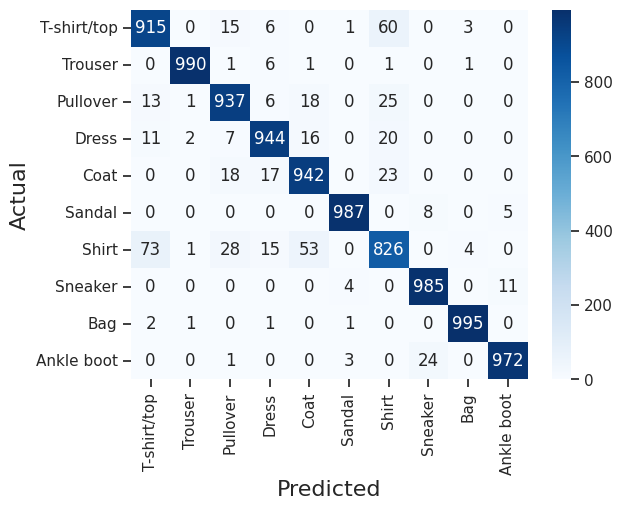


Final model test_accuracy (Top-1 accuracy):  94.93

Final model test_loss:  0.18866165429353715


In [ ]:
criterion = nn.CrossEntropyLoss()

SimpleNet = SimpleNet2([2,2,2],1,32,2,512)
opt_base = optim.SGD

if torch.cuda.device_count() > 1:
    SimpleNet = nn.DataParallel(SimpleNet)
    SimpleNet = SimpleNet.to(device)
else:
    SimpleNet = SimpleNet.to(device)
optimizer = SAM(SimpleNet.parameters(), opt_base, lr=0.014987, momentum=0.96, weight_decay=0.000619)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
for epoch in range(70):
    for data in trainloader:
        img, label = data 
        img = img.to(device)
        label = label.to(device)
        outputs = SimpleNet(img)
        loss = criterion(outputs, label)  # use this loss for any training statistics
        loss.backward()
        optimizer.first_step(zero_grad=True)
        outputs = SimpleNet(img)
      # second forward-backward pass
        criterion(outputs, label).backward()  # make sure to do a full forward pass
        optimizer.second_step(zero_grad=True)
    scheduler.step()

# Evaluation with test set - only return test_accuracy
test_loss, test_accuracy, wrong_samples, wrong_preds, actual_preds = eval(SimpleNet,criterion,testloader,'Final Model')
print('\nFinal model test_accuracy (Top-1 accuracy): ',test_accuracy)
print('\nFinal model test_loss: ',test_loss)

| Highest f1-scores | Class | Actual/Predicted |
|---|---|---|
| 0.99+ | Bag | 995/1000 |
| 0.99+ | Trouser | 990/1000 |
| 0.99+ |  Sandal | 987/1000 |
<br>

| Lowest f1-scores | Class | Actual/Predicted |
|---|---|---|
| 0.85 | Shirt | 826/1000 |
| 0.91 | T_shirt | 915/1000 |
| 0.93 | Coat | 942/1000 |

#### Some observations to point out
Seems that the final top-1 accuracy of our model is 94.93% which is about 0.4+% less than the hyperparameter's best validation accuracy, which is not surprising because I would say the validation set is overused many times that it is almost fitting too well to my validation set, even though I didn't use any validation set data as my training data during model improvement, I always choose the best hyperparameters and data augmentation based on the best and highest validation accuracy that it is almost fitting too well on it.<br><br>

Generally, classes with the highest f1-scores have more differing and distinct features, for example 'bag' does not look like any other classes it is quite distinct, compared to the classes with lower f1-scores such as 'shirt' and 'T_shirt' they can technially be identified as the same object, and they look very similar to one another.

### 5.2) Error Analysis

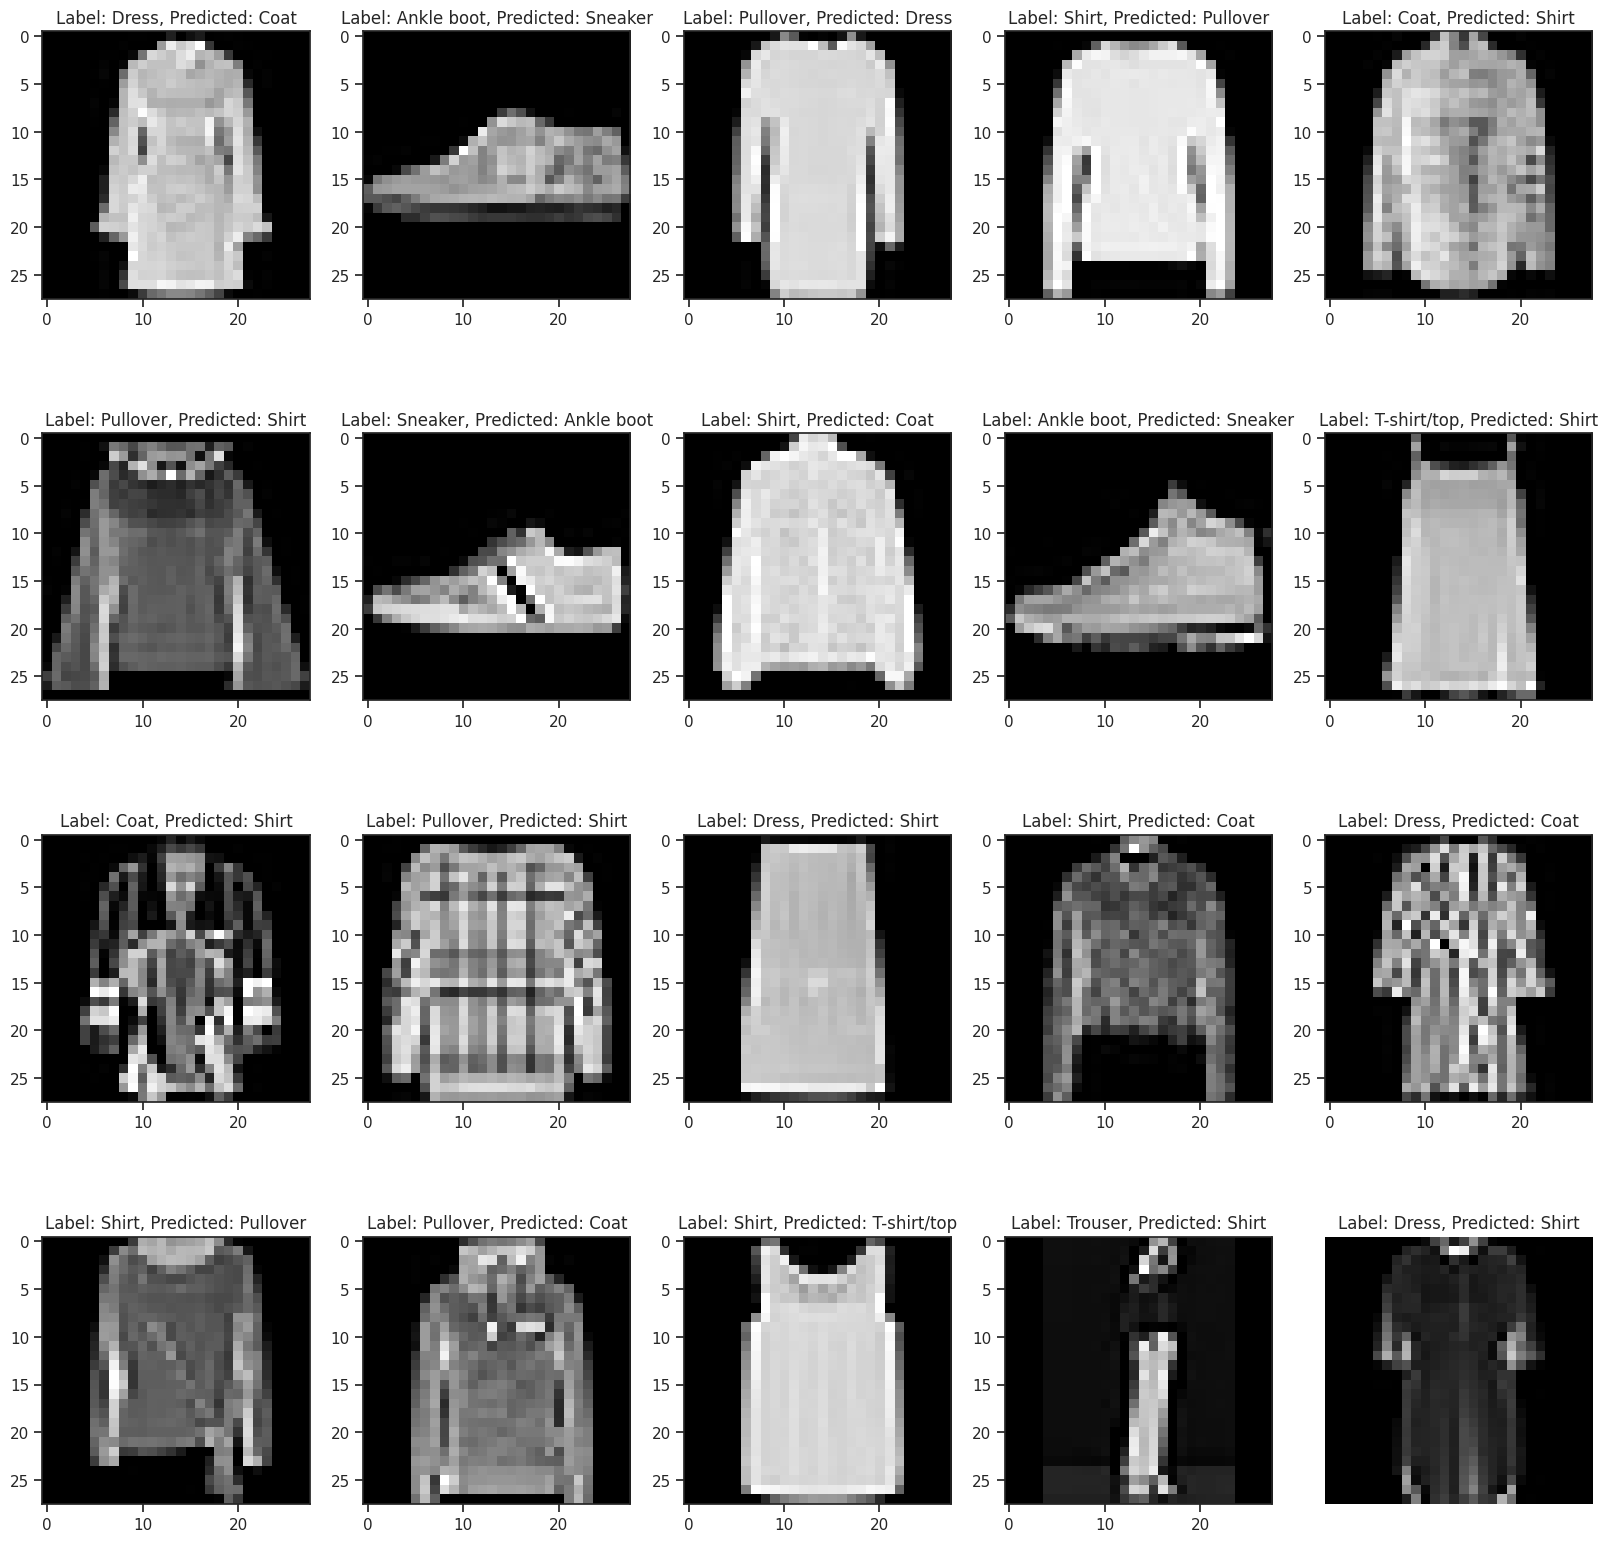

In [ ]:
random_idxs = np.random.choice(wrong_preds.shape[0], 20, replace=False)

fig, ax = plt.subplots(4, 5, figsize=(20, 20))
plt.axis("off")
for idx, subplot in zip(random_idxs, ax.ravel()):
    pred = class_labels[wrong_preds.type('torch.LongTensor')[idx]]
    actual = class_labels[actual_preds.type('torch.LongTensor')[idx]]
    subplot.imshow(wrong_samples.cpu().numpy().reshape(wrong_samples.shape[0],28,28)[idx], cmap='gray')
    subplot.set_title(f"Label: {actual}, Predicted: {pred}")

Generally, 'T_shirt' are predicted as 'shirt', vice versa, and some of the mistaken prediction is something I could understand. For example, some of the clothes have overlapping features (these features were talked about during EDA #1.2.1) with something like 'Coat', as coats have generally a long sleeve

### 5.3) Filter Analysis
- Visualizing just the first layer
- Later layers becomes incoherent to visualize and understand

Getting all the filters for our final model

In [ ]:
layers = []
for parm in SimpleNet.parameters():
    layers.append(parm)

Visualizating first convolutional layer filter weights (32 filters)
- Referenced off [stackoverflow, Low 2019](https://stackoverflow.com/questions/55594969/how-to-visualise-filters-in-a-cnn-with-pytorch) *Thank you mysterious stackoverflow man*
- Brighter -> Higher weight value

<Figure size 800x500 with 0 Axes>

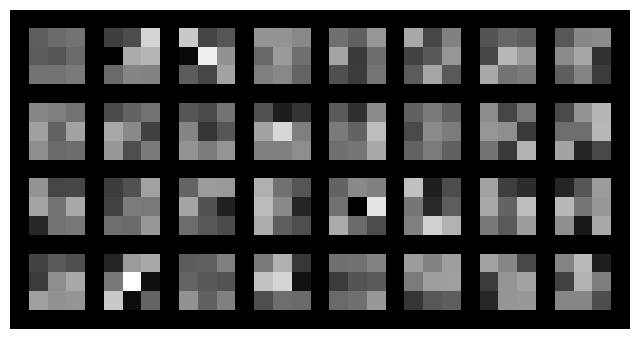

In [ ]:
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

filter = layers[0].data.cpu().clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

This looks rather incomprehensible. I will use a sample image to form a feature map and try to visualise what type of feature is being extracted, and apply filter labels to all of them.

Applying the weights of our layers to a functional conv2d with a sample image as our input
- Input: Sample image
- Sample image -> Filter Weights -> Output (Feature Map)
- Code not referenced (not much online resource)...there might be a better way to do feature mapping in PyTorch

In [ ]:
def featureMap(convWeights,image_input,plotX=8,plotY=4):
    cuda0 = torch.device('cuda:0')
    image_np = image_input.cpu().numpy()
    image_map = F.conv2d(image_input.to(cuda0), convWeights.data.to(cuda0), padding=1)
    image_map = image_map.cpu()
    fig, ax = plt.subplots(plotY, plotX, figsize=(20, 20))
    for i, subplot in enumerate(ax.ravel()):
        image = image_map[i]
        subplot.imshow(image, cmap="gray")
        subplot.set_title(f"Filter {i+1}")
        subplot.axis("off")
    plt.show()

Original images of sample 0 & 1

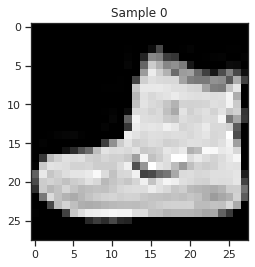

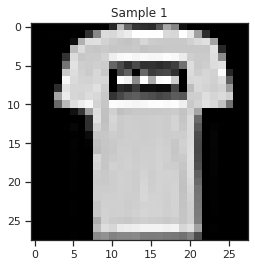

In [ ]:
plt.imshow(train_input_np[0], cmap='gray')
plt.title('Sample 0')
plt.show()
plt.imshow(train_input_np[1], cmap='gray')
plt.title('Sample 1')
plt.show()

I will just analysis the feature maps of 2 sample image (Comparing all would be too long)

Shoe feature map


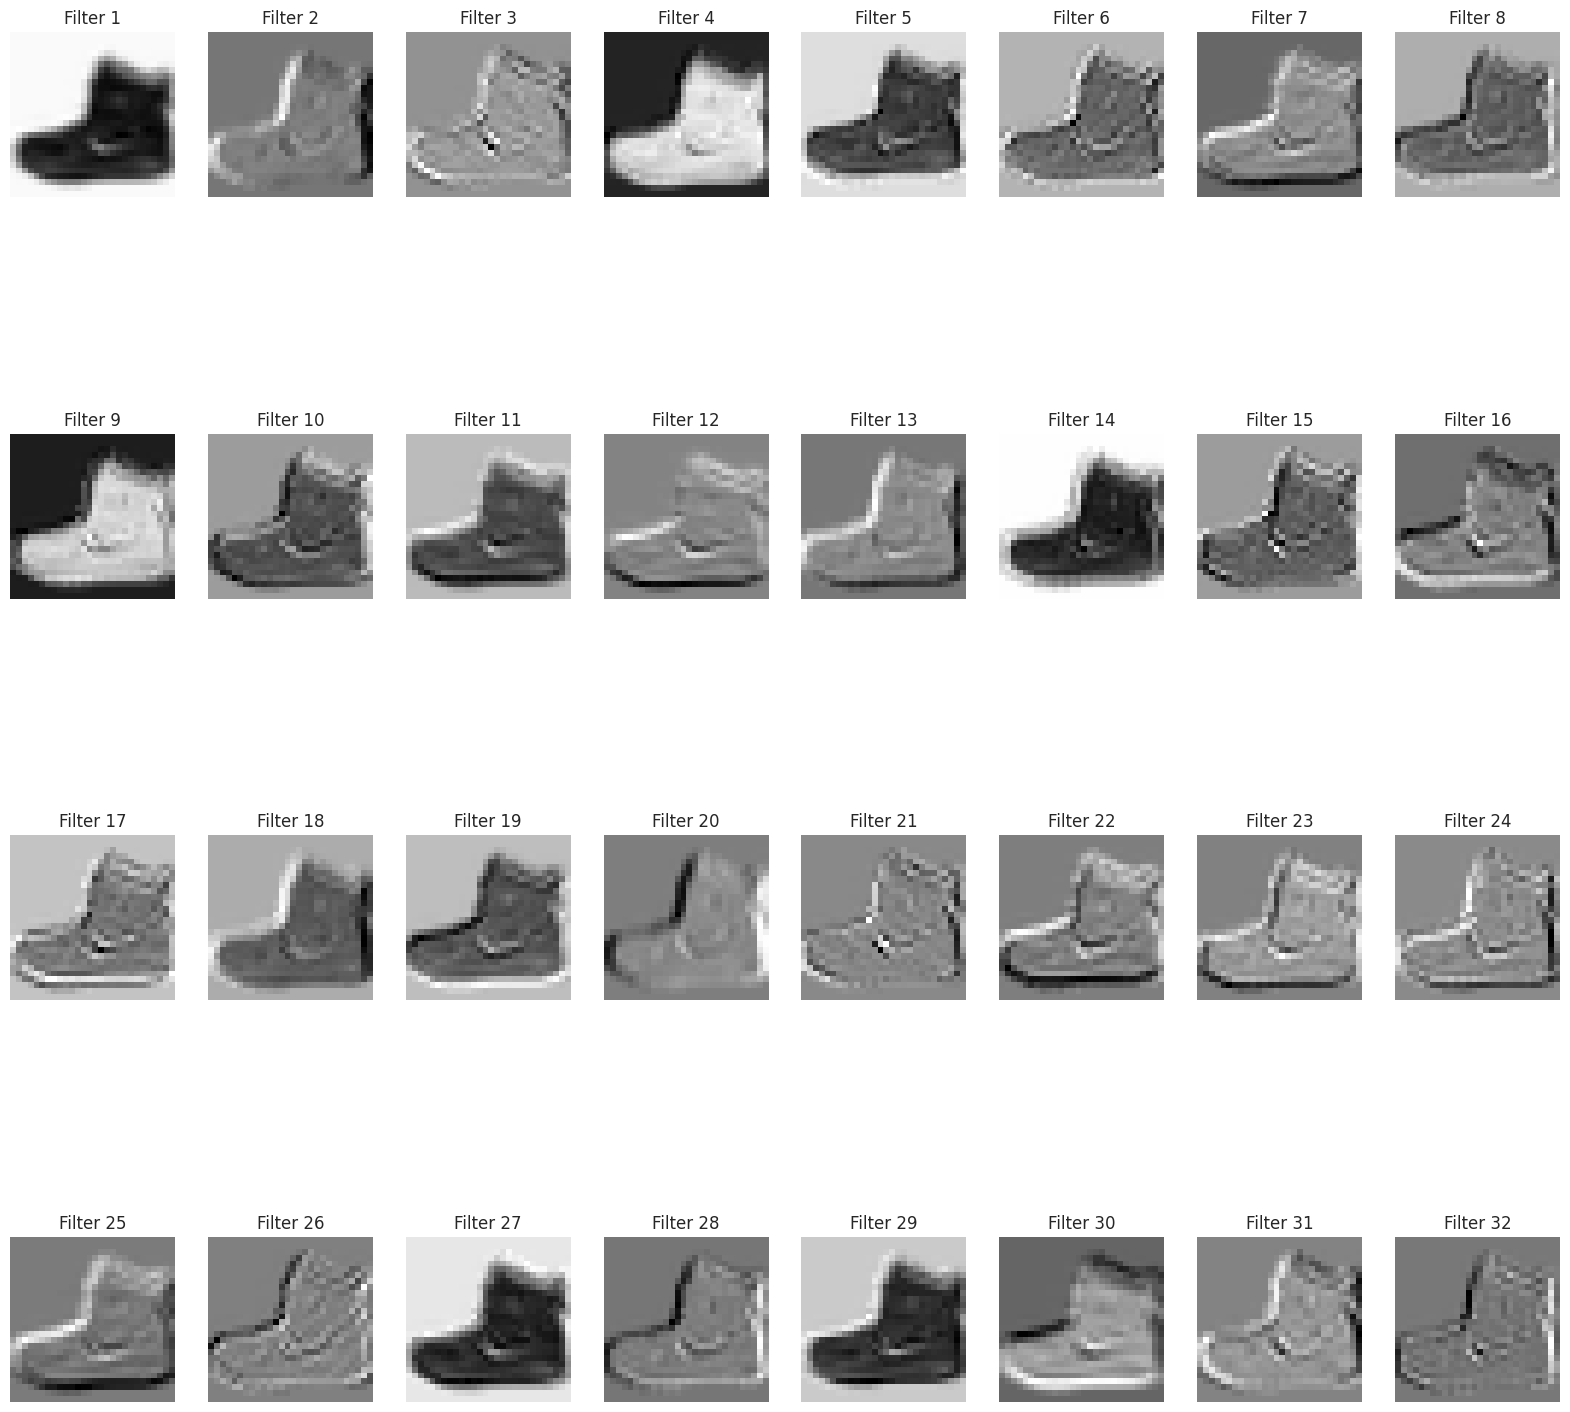


Shirt feature map


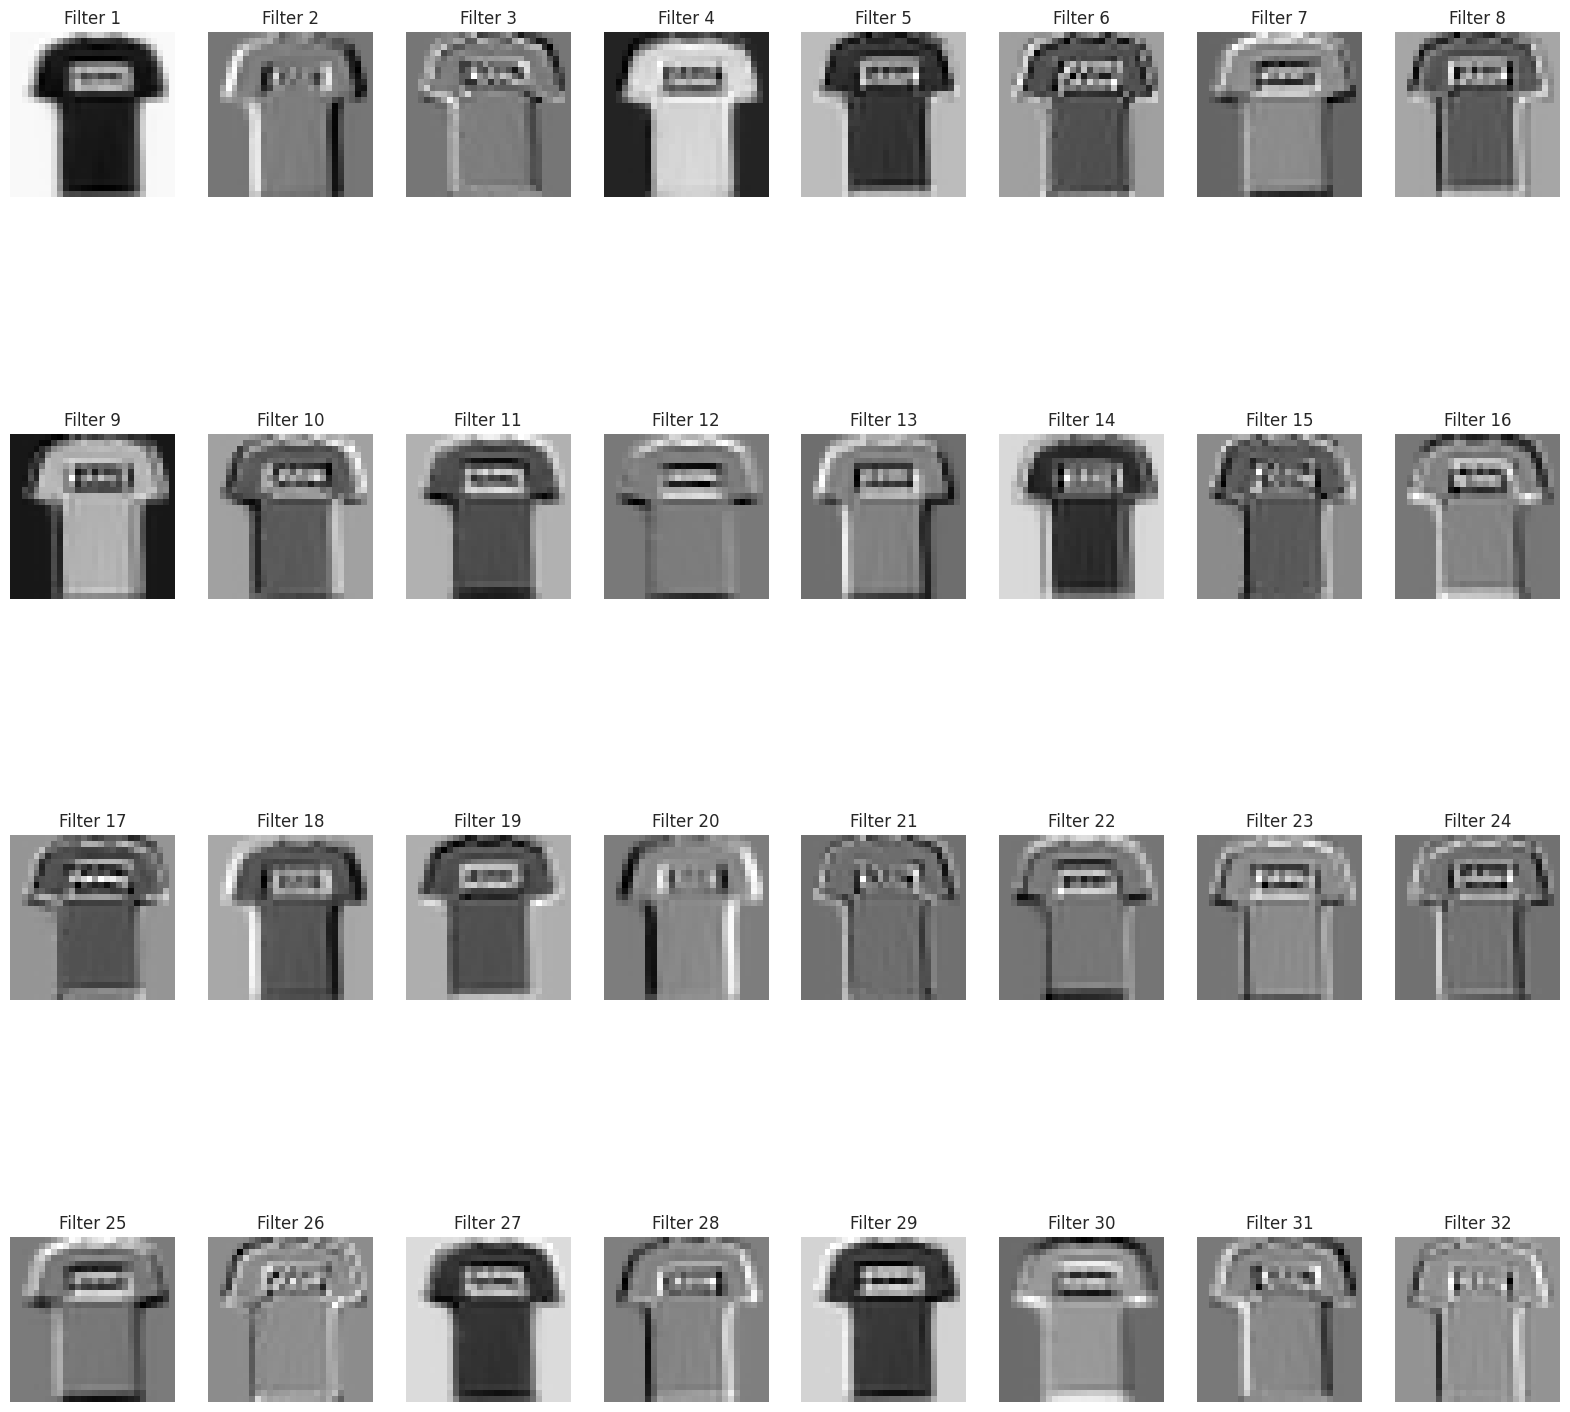

In [ ]:
print('Shoe feature map')
featureMap(layers[0],train_input[0],8,4)

print('\nShirt feature map')
featureMap(layers[0],train_input[1],8,4)

Just from looking at these 2 feature maps I can sort of tell what the filter is kind of taking. For example, filter 1,27,29 is inversed and gets a good general shape of the image. Filters 10, 20, 26, 28 are getting more features on the right edges of the object (more activated - brighter). Filters 2, 7, 13, 18 are getting more features on the left edges of the objects. Maybe a few filters might seem redundant or too similar as this is a simple dataset and maybe choose a simpler model...but I can't really guess the importance of each filter since although the there are filters that might not look significant or similar but down the neutral network it might contribute a lot of 'activation' for a particular class.

Final model file is likely removed before submission

In [ ]:
torch.save(SimpleNet,'PartA_FinalModel')

All in all, I was able to slowly improve my model along this FashionMNIST CNN journey. I have learnt many essential fundamentals of CNN such as not being afraid to explore different architectures, and even modifying it and exploring more efficient ways to improve my model. From this experience, I am well-equipped to explore harder datasets such as CIFAR100.

End of Part A